In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import json

# The file appears to be space/whitespace separated
# Using delimiter=r'\s+' to handle multiple spaces/tabs
info = pd.read_csv('info.txt', delimiter=r'\s+')

# Filter columns: keep 'runid' and columns starting with 'ocn.' but exclude 'ocean_fw'
ocn_columns = [col for col in info.columns if col.startswith('ocn.')]
columns_to_keep = ['runid'] + ocn_columns

# Remove 'ocean_fw' if it exists in the selected columns
if 'ocn.l_noise_fw' in columns_to_keep:
    columns_to_keep.remove('ocn.l_noise_fw')

# Select only the desired columns
params = info[columns_to_keep]

# Display the results
print("Original shape:", info.shape)
print("Filtered shape:", params.shape)
print("\nKept columns:")
print(params.columns.tolist())
print("\nFirst 5 rows of filtered data:")
print(params.head())

Original shape: (99, 8)
Filtered shape: (99, 7)

Kept columns:
['runid', 'ocn.diff_dia_min', 'ocn.drag_topo_fac', 'ocn.slope_max', 'ocn.diff_iso', 'ocn.diff_gm', 'ocn.diff_dia_max']

First 5 rows of filtered data:
   runid  ocn.diff_dia_min  ocn.drag_topo_fac  ocn.slope_max  ocn.diff_iso  \
0      1          0.000010           2.816063       0.001247   1615.606127   
1      2          0.000010           2.760967       0.000817   1440.298245   
2      3          0.000011           2.553815       0.001108   1648.789119   
3      4          0.000010           3.425434       0.000784   1373.056807   
4      5          0.000011           2.281333       0.001231   1309.914618   

   ocn.diff_gm  ocn.diff_dia_max  
0  1178.446903          0.000139  
1  1156.620678          0.000179  
2  1727.339243          0.000151  
3  1172.548331          0.000140  
4  1594.469916          0.000136  


In [2]:
# Basic descriptive statistics
print("\nDescriptive Statistics:")
print(params.describe())


Descriptive Statistics:
           runid  ocn.diff_dia_min  ocn.drag_topo_fac  ocn.slope_max  \
count  99.000000         99.000000          99.000000      99.000000   
mean   50.000000          0.000010           2.997310       0.001000   
std    28.722813          0.000001           0.436868       0.000146   
min     1.000000          0.000008           2.264693       0.000751   
25%    25.500000          0.000009           2.625165       0.000875   
50%    50.000000          0.000010           2.988873       0.000998   
75%    74.500000          0.000011           3.376068       0.001124   
max    99.000000          0.000012           3.749145       0.001247   

       ocn.diff_iso  ocn.diff_gm  ocn.diff_dia_max  
count     99.000000    99.000000         99.000000  
mean    1497.397723  1500.157923          0.000150  
std      216.836888   219.136266          0.000022  
min     1130.438668  1126.433930          0.000113  
25%     1312.015546  1313.820452          0.000132  
50%     

In [3]:
# Find all ocn_ts.nc files
model_files = []
run_labels = []

for run_id in range(100):
    file_path = f"{run_id}/ocn_ts.nc"
    if os.path.exists(file_path):
        model_files.append(file_path)
        run_labels.append(str(run_id))


## Simpler summary statistics

In [4]:
import numpy as np

def compute_simple_summary_stats(amoc_data, time_data=None, 
                                remove_spinup=False, spinup_fraction=0.1, n_bins=10):
    """
    Compute simple summary statistics for AMOC time series.
    
    Parameters:
    -----------
    amoc_data : array-like
        AMOC strength time series
    time_data : array-like, optional
        Time values (if None, assumes uniform spacing)
    remove_spinup : bool
        Whether to remove initial spinup period
    spinup_fraction : float
        Fraction of data to remove as spinup (default 0.1 = 10%)
    
    Returns:
    --------
    dict : Summary statistics
    """
    
    amoc_data = np.asarray(amoc_data)
    
    # Remove spinup if requested
    if remove_spinup:
        start_idx = int(len(amoc_data) * spinup_fraction)
        amoc_data = amoc_data[start_idx:]
    
    # Define fixed bins for consistency across all simulations
    bins = np.linspace(0, 35, n_bins+1)  # 10 bins: [0-3], [3-6], ..., [27-30]
    
    # Calculate bin frequencies for ML emulator
    bin_counts, _ = np.histogram(amoc_data, bins=bins)
    bin_frequencies = bin_counts / len(amoc_data)  # Normalize to [0,1]
    
    # Simplified statistics
    stats = {
        'mean': np.mean(amoc_data),
        'std': np.std(amoc_data),
        'q25': np.percentile(amoc_data, 25),
        'q75': np.percentile(amoc_data, 75),
        'bin_frequencies': bin_frequencies,
    }
    
    return stats

# Helper function to get bins for plotting
def get_amoc_bins(n_bins):
    """Return the standard AMOC bins used across all functions."""
    return np.linspace(0, 35, n_bins+1)

In [5]:
# Default run
default_file = "../default_long_run/ocn_ts.nc"
ds_default = xr.open_dataset(default_file)
amoc_default = ds_default.amoc26N.values
time_default = ds_default.time.values
ds_default.close()

# Compute default summary statistics
default_stats = compute_simple_summary_stats(amoc_default, time_default)
print(f"Default stats computed: {list(default_stats.keys())}")

print(f"Number of ensemble files: {len(model_files)}")

# Ensemble runs
ensemble_stats = []
for i, file in enumerate(model_files):
    ds = xr.open_dataset(file)
    amoc = ds.amoc26N.values
    time = ds.time.values
    ds.close()
    
    stats = compute_simple_summary_stats(amoc, time)
    ensemble_stats.append(stats)

print(f"Total ensemble stats computed: {len(ensemble_stats)}")
print(f"Each run has {len(ensemble_stats[0])} summary statistics")

Default stats computed: ['mean', 'std', 'q25', 'q75', 'bin_frequencies']
Number of ensemble files: 99
Total ensemble stats computed: 99
Each run has 5 summary statistics


In [6]:
def plot_amoc_ensemble_simple(ensemble_stats, model_files, amoc_default, default_stats, 
                             n_runs=None, figsize_per_run=3, n_bins=10):
    """
    Plot AMOC time series and histograms for ensemble runs.
    
    Parameters:
    -----------
    ensemble_stats : list
        List of stats dictionaries from compute_simple_summary_stats
    model_files : list
        List of file paths for ensemble runs
    amoc_default : array-like
        Default/reference AMOC time series
    default_stats : dict
        Stats dictionary for default run
    n_runs : int, optional
        Number of runs to plot (if None, plots all)
    figsize_per_run : float
        Figure height per run in inches
    """
    
    if n_runs is None:
        n_runs = len(ensemble_stats)
    
    fig, axes = plt.subplots(n_runs, 2, figsize=(12, figsize_per_run * n_runs), 
                            gridspec_kw={'width_ratios': [3, 2]})
    
    # Handle single run case
    if n_runs == 1:
        axes = [axes]
    
    for i, (stats, file) in enumerate(zip(ensemble_stats[:n_runs], model_files[:n_runs])):
        ds = xr.open_dataset(file)
        amoc = ds.amoc26N.values
        ds.close()
        
        # ----------------------------
        # 1. Time series plot
        # ----------------------------
        axes[i][0].plot(amoc, color='darkblue', alpha=0.8, label='Ensemble')
        axes[i][0].plot(amoc_default, color='lightcoral', alpha=0.8, label='Default')
        
        # Add horizontal lines for key statistics
        axes[i][0].axhline(stats['mean'], color='darkblue', linestyle='-', alpha=0.3, label='Mean (Ens)')
        axes[i][0].axhline(default_stats['mean'], color='lightcoral', linestyle='-', alpha=0.3, label='Mean (Def)')
        axes[i][0].axhline(stats['q25'], color='darkblue', linestyle='--', alpha=0.3)
        axes[i][0].axhline(stats['q75'], color='darkblue', linestyle='--', alpha=0.3)
        
        axes[i][0].set_ylabel('AMOC (Sv)')
        axes[i][0].set_xlabel('Time')
        axes[i][0].set_title(f'AMOC Time Series - Run {i+1}')
        axes[i][0].legend()
        axes[i][0].grid(alpha=0.3)
        
        # Add summary stats text box
        stats_text = (
            f"Mean: {stats['mean']:.1f} Sv (Def: {default_stats['mean']:.1f})\n"
            f"Std: {stats['std']:.1f} Sv (Def: {default_stats['std']:.1f})\n"
            f"Q25-Q75: {stats['q25']:.1f}-{stats['q75']:.1f} Sv\n"
        )
        
        axes[i][0].text(
            0.98, 0.02, stats_text,
            transform=axes[i][0].transAxes,
            fontsize=8, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
        )
        
        # ----------------------------
        # 2. Histogram plot (bins defined in plotting function)
        # ----------------------------
        # Define bins in plotting function for flexibility
        bins = get_amoc_bins(n_bins)
        
        # Plot histograms - matplotlib calculates frequencies automatically
        axes[i][1].hist(amoc, bins=bins, alpha=0.7, color='darkblue', 
                       label='Ensemble', density=True, edgecolor='black')
        axes[i][1].hist(amoc_default, bins=bins, alpha=0.5, color='lightcoral', 
                       label='Default', density=True, edgecolor='black')
        
        # Add vertical lines for key statistics
        axes[i][1].axvline(stats['mean'], color='darkblue', linestyle='-', alpha=0.8, label='Mean (Ens)')
        axes[i][1].axvline(default_stats['mean'], color='lightcoral', linestyle='-', alpha=0.8, label='Mean (Def)')
        axes[i][1].axvline(stats['q25'], color='darkblue', linestyle='--', alpha=0.7, label='Q25/Q75 (Ens)')
        axes[i][1].axvline(stats['q75'], color='darkblue', linestyle='--', alpha=0.7)
        
        axes[i][1].set_xlabel('AMOC (Sv)')
        axes[i][1].set_ylabel('Density')
        axes[i][1].set_title(f'AMOC Distribution - Run {i+1}')
        axes[i][1].legend()
        axes[i][1].grid(alpha=0.3)
        axes[i][1].set_xlim(0, 35)
    
    plt.tight_layout()
    plt.show()

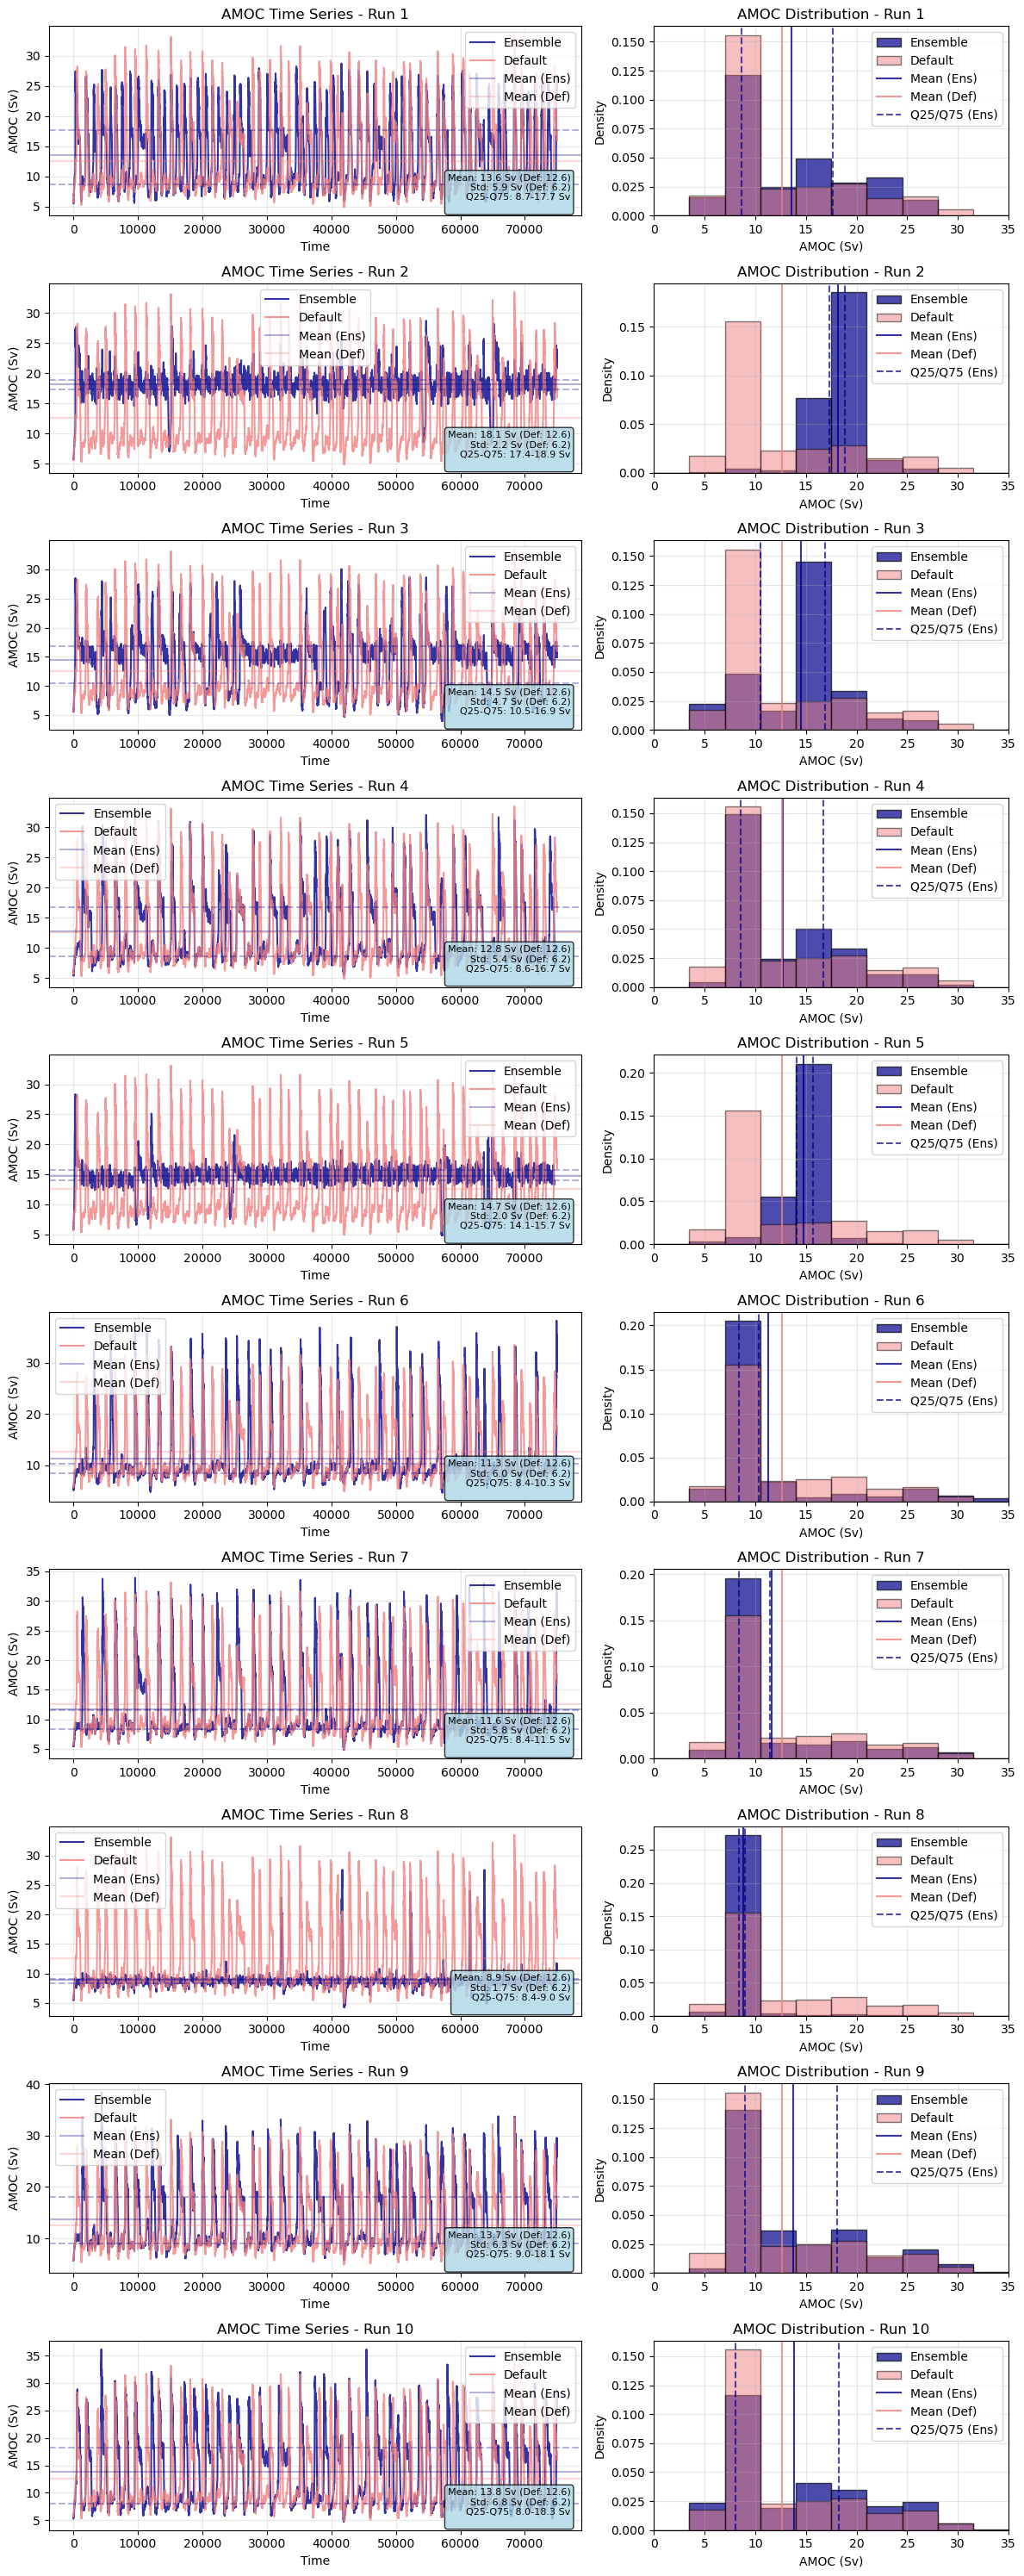

In [7]:
plot_amoc_ensemble_simple(ensemble_stats, model_files, amoc_default, default_stats, 
                             n_runs=10, figsize_per_run=3)

In [8]:
# ----------------------------
# 1. Prepare data
# ----------------------------
param_cols = ['ocn.diff_dia_min', 'ocn.drag_topo_fac', 'ocn.slope_max',
              'ocn.diff_iso', 'ocn.diff_gm', 'ocn.diff_dia_max']
X = params[param_cols].values
bin_frequencies = np.array([s['bin_frequencies'] for s in ensemble_stats])
other_stats = np.array([[s['mean'], s['std'], s['q25'], s['q75']] 
                       for s in ensemble_stats])

print(f"Training on {X.shape[0]} runs with {X.shape[1]} parameters")
print(f"Each distribution has {bin_frequencies.shape[1]} bins")


Training on 99 runs with 6 parameters
Each distribution has 10 bins


In [9]:
def crossvalidation_bins(X, Y, bin_frequencies, emulator_class, emulator_params=None, cv=5,
                        output_names=['mean', 'std', 'q25', 'q75']):
    """
    Cross-validation for bin-based emulator with Matern kernels.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_parameters)
        Input parameters
    Y : array-like, shape (n_samples, n_stats)
        Summary statistics (mean, std, q25, q75)
    bin_frequencies : array-like, shape (n_samples, n_bins)
        Bin frequencies for each sample
    emulator_class : class
        Emulator class (e.g., GPEmulatorBins)
    emulator_params : dict, optional
        Parameters for emulator initialization
    cv : int
        Number of cross-validation folds
    output_names : list
        Names of output statistics
    
    Returns
    -------
    results : dict
        Cross-validation results with mean scores
    """
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    
    if emulator_params is None:
        emulator_params = {}
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=43)
    
    bin_rmses = []
    bin_sup_diffs = []  # Maximum error across all bins
    individual_rmses = {name: [] for name in output_names}
    bin_r2_scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]  
        bins_train, bins_test = bin_frequencies[train_idx], bin_frequencies[test_idx]
        
        # Fit and predict
        emulator = emulator_class(**emulator_params)
        emulator.fit(X_train, Y_train, bins_train)
        bins_pred, Y_pred = emulator.predict(X_test)
        
        # Bin frequency metrics
        bin_rmse = np.sqrt(mean_squared_error(bins_test.flatten(), bins_pred.flatten()))
        bin_rmses.append(bin_rmse)
        
        # Bin supremum difference (max pointwise error across all test samples)
        bin_pointwise_errors = np.abs(bins_test - bins_pred)  # shape: (n_test, n_bins)
        bin_sup_diff = np.max(bin_pointwise_errors)  # maximum error over all bins and test samples
        bin_sup_diffs.append(bin_sup_diff)
        
        # Overall R² score
        per_bin_r2 = [r2_score(bin_test[:, i], bin_pred[:, i]) for i in range(10)]

        #for i, r2 in enumerate(per_bin_r2):
        #    print(f"Bin {i}: R² = {r2:.3f}")
            
        r2score = r2_score(bins_test, bins_pred)
        bin_r2_scores.append(r2score)
        
        # Individual summary statistics RMSEs
        for i, name in enumerate(output_names):
            if i < Y_test.shape[1]:
                rmse = np.sqrt(mean_squared_error(Y_test[:, i], Y_pred[:, i]))
                individual_rmses[name].append(rmse)
    
    # Calculate means across all folds
    results = {
        'bins_rmse': np.mean(bin_rmses),
        'bins_max_error': np.mean(bin_sup_diffs),
        'r2_per_bin': per_bin_r2
    }
    
    # Add individual statistics means
    for name in output_names:
        if len(individual_rmses[name]) > 0:
            results[f'{name}_rmse'] = np.mean(individual_rmses[name])
    
    return results

# NNs

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class NNEmulatorBins:
    def __init__(self,
                 n_parameters,
                 n_bins,
                 n_other_stats=0,
                 predict_stats=True,
                 use_softmax=False,  # NEW: Option for softmax
                 n_hidden_layers=2,       
                 n_nodes=32,              
                 activation="relu",
                 learning_rate=1e-3,
                 l2_reg=1e-4,             
                 dropout_rate=0.2,        
                 patience=20):
        """
        Keras NN emulator for bin frequencies + optional summary stats.

        Parameters
        ----------
        n_parameters : int
            Number of input parameters.
        n_bins : int
            Number of bin frequencies to predict.
        n_other_stats : int, default=0
            Number of additional summary statistics.
        predict_stats : bool, default=False
            If True, predict both bins and stats. If False, only predict bins.
        use_softmax : bool, default=False
            If True, use softmax activation for bins (only valid when predict_stats=False).
            When True, bins are NOT scaled and automatically sum to 1.
        """
        self.n_parameters = n_parameters
        self.n_bins = n_bins
        self.n_other_stats = n_other_stats
        self.predict_stats = predict_stats
        self.use_softmax = use_softmax
        
        # Validation
        if self.use_softmax and self.predict_stats:
            raise ValueError("use_softmax=True is only valid with predict_stats=False")
        
        # Output dimension
        if self.predict_stats:
            self.output_dim = n_bins + n_other_stats
        else:
            self.output_dim = n_bins

        # Scalers
        self.scaler_X = StandardScaler()
        if self.use_softmax:
            # Don't scale bins when using softmax
            self.scaler_bins = None
        else:
            self.scaler_bins = StandardScaler()
        
        if self.predict_stats:
            self.scaler_stats = StandardScaler()
        else:
            self.scaler_stats = None
            
        self.is_fitted = False
        self.patience = patience

        # Store hyperparameters
        self.n_hidden_layers = n_hidden_layers
        self.n_nodes = n_nodes
        self.activation = activation
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate

        self.model = self._build_model()

    def _build_model(self):
        inputs = keras.Input(shape=(self.n_parameters,))
        x = inputs

        # Choose activation
        if self.activation.lower() == "relu":
            act_fn = layers.ReLU()
        elif self.activation.lower() in ["leakyrelu", "leaky_relu"]:
            act_fn = layers.LeakyReLU(alpha=0.01)
        else:
            raise ValueError("activation must be 'relu' or 'leaky_relu'")

        # Hidden layers
        for _ in range(self.n_hidden_layers):
            x = layers.Dense(self.n_nodes,
                             kernel_regularizer=keras.regularizers.l2(self.l2_reg))(x)
            x = act_fn(x)
            x = layers.Dropout(self.dropout_rate)(x)

        # Output layer
        if self.use_softmax:
            # Softmax for bins (bins-only mode)
            outputs = layers.Dense(self.output_dim, activation='softmax')(x)
        else:
            # Linear output (default)
            outputs = layers.Dense(self.output_dim)(x)

        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(self.learning_rate),
            loss="mse"
        )
        return model

    def _normalize_bin_frequencies(self, bin_frequencies):
        """Normalize bin frequencies to sum to 1."""
        bin_frequencies = np.clip(bin_frequencies, 0, None)
        row_sums = bin_frequencies.sum(axis=1, keepdims=True)
        row_sums = np.where(row_sums == 0, 1, row_sums)
        return bin_frequencies / row_sums

    def fit(self, X, Y, bin_frequencies, epochs=200, batch_size=8, verbose=0):
        """
        Train the model.
        """
        # Validation
        if self.predict_stats and Y is None:
            raise ValueError("Y must be provided when predict_stats=True")
        
        # Reset scalers
        self.scaler_X = StandardScaler()
        if not self.use_softmax:
            self.scaler_bins = StandardScaler()
        if self.predict_stats:
            self.scaler_stats = StandardScaler()
    
        # Prepare data
        X_scaled = self.scaler_X.fit_transform(X)
        
        if self.use_softmax:
            # With softmax: use raw normalized bins (no scaling)
            bin_frequencies_norm = self._normalize_bin_frequencies(bin_frequencies)
            Y_scaled = bin_frequencies_norm
        else:
            # Without softmax: normalize then scale
            bin_frequencies_norm = self._normalize_bin_frequencies(bin_frequencies)
            bins_scaled = self.scaler_bins.fit_transform(bin_frequencies_norm)
            
            if self.predict_stats:
                stats_scaled = self.scaler_stats.fit_transform(Y)
                Y_scaled = np.hstack([bins_scaled, stats_scaled])
            else:
                Y_scaled = bins_scaled
    
        self.model.fit(
            X_scaled, Y_scaled,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )
    
        self.is_fitted = True

    def predict(self, X_new):
        """
        Predict bins and optionally stats.
        """
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted first.")
        
        X_scaled = self.scaler_X.transform(X_new)
        preds = self.model.predict(X_scaled, verbose=0)
        
        if self.use_softmax:
            # Softmax output is already normalized, no post-processing needed
            bin_frequencies_pred = preds
            Y_pred = None
        elif self.predict_stats:
            # Split and inverse transform
            bins_scaled = preds[:, :self.n_bins]
            stats_scaled = preds[:, self.n_bins:]
            
            bin_frequencies_pred = self.scaler_bins.inverse_transform(bins_scaled)
            Y_pred = self.scaler_stats.inverse_transform(stats_scaled)
            
            # Normalize bins
            bin_frequencies_pred = self._normalize_bin_frequencies(bin_frequencies_pred)
        else:
            # Bins only without softmax
            bin_frequencies_pred = self.scaler_bins.inverse_transform(preds)
            Y_pred = None
            
            # Normalize bins
            bin_frequencies_pred = self._normalize_bin_frequencies(bin_frequencies_pred)
        
        return bin_frequencies_pred, Y_pred
    
    def score(self, X_test, Y_test, bin_frequencies_test):
        """Keep original signature - Y_test can be None if predict_stats=False."""
        bin_pred, Y_pred = self.predict(X_test)
        
        scores = {"bin_frequencies_r2": r2_score(bin_frequencies_test, bin_pred)}
        
        if self.predict_stats:
            if Y_test is None:
                raise ValueError("Y_test required when predict_stats=True")
            scores["other_stats_r2"] = r2_score(Y_test, Y_pred)
            scores["overall_r2"] = r2_score(
                np.hstack([bin_frequencies_test, Y_test]),
                np.hstack([bin_pred, Y_pred])
            )
        
        return scores

    # -------------------------------------------------------------------------
    # TensorFlow-differentiable scaling helpers
    # -------------------------------------------------------------------------
    def _tf_scale_X(self, X):
        mean = tf.constant(self.scaler_X.mean_, dtype=tf.float32)
        scale = tf.constant(self.scaler_X.scale_, dtype=tf.float32)
        return (X - mean) / scale

    def _tf_scale_bins(self, bins):
        mean = tf.constant(self.scaler_bins.mean_, dtype=tf.float32)
        scale = tf.constant(self.scaler_bins.scale_, dtype=tf.float32)
        return (bins - mean) / scale

    def _tf_inverse_scale_bins(self, bins_scaled):
        mean = tf.constant(self.scaler_bins.mean_, dtype=tf.float32)
        scale = tf.constant(self.scaler_bins.scale_, dtype=tf.float32)
        return bins_scaled * scale + mean

    def _tf_scale_stats(self, stats):
        if not self.predict_stats:
            raise RuntimeError("Cannot scale stats when predict_stats=False")
        mean = tf.constant(self.scaler_stats.mean_, dtype=tf.float32)
        scale = tf.constant(self.scaler_stats.scale_, dtype=tf.float32)
        return (stats - mean) / scale

    def _tf_inverse_scale_stats(self, stats_scaled):
        if not self.predict_stats:
            raise RuntimeError("Cannot inverse scale stats when predict_stats=False")
        mean = tf.constant(self.scaler_stats.mean_, dtype=tf.float32)
        scale = tf.constant(self.scaler_stats.scale_, dtype=tf.float32)
        return stats_scaled * scale + mean

    # -------------------------------------------------------------------------
    # Gradient-based calibration
    # -------------------------------------------------------------------------
    def calibrate(self, y_target, bounds=None, n_iter=500, lr=1e-2, verbose=True):
        """
        Gradient-based calibration of input parameters.

        Parameters
        ----------
        y_target : array-like, shape (n_bins,) or (n_bins + n_other_stats,)
            Observed target output. If predict_stats=False, only bins.
            If predict_stats=True, bins + stats.
        bounds : list of (low, high) tuples or None
            Parameter bounds. If None, unconstrained.
        n_iter : int
            Number of optimization steps.
        lr : float
            Learning rate.
        """
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted first.")

        y_target = np.asarray(y_target).reshape(1, -1)
        
        # Scale target appropriately
        if self.predict_stats:
            target_bins = y_target[:, :self.n_bins]
            target_stats = y_target[:, self.n_bins:]
            target_bins_scaled = (target_bins - self.scaler_bins.mean_) / self.scaler_bins.scale_
            target_stats_scaled = (target_stats - self.scaler_stats.mean_) / self.scaler_stats.scale_
            y_target_scaled = np.hstack([target_bins_scaled, target_stats_scaled])
        else:
            target_bins_scaled = (y_target - self.scaler_bins.mean_) / self.scaler_bins.scale_
            y_target_scaled = target_bins_scaled
            
        y_target_scaled = tf.constant(y_target_scaled, dtype=tf.float32)

        # Initialize parameter vector
        theta = tf.Variable(tf.random.normal((1, self.n_parameters)), dtype=tf.float32)

        if bounds is not None:
            lower = tf.constant([b[0] for b in bounds], dtype=tf.float32)
            upper = tf.constant([b[1] for b in bounds], dtype=tf.float32)

        opt = tf.keras.optimizers.Adam(learning_rate=lr)

        for i in range(n_iter):
            with tf.GradientTape() as tape:
                # Apply bounds (if any)
                if bounds is not None:
                    theta_bounded = lower + tf.sigmoid(theta) * (upper - lower)
                else:
                    theta_bounded = theta

                # Scale X and forward pass
                X_scaled = self._tf_scale_X(theta_bounded)
                y_pred_scaled = self.model(X_scaled, training=False)

                # MSE loss in scaled space
                loss = tf.reduce_mean(tf.square(y_pred_scaled - y_target_scaled))

            grads = tape.gradient(loss, [theta])
            opt.apply_gradients(zip(grads, [theta]))

            if verbose and i % 50 == 0:
                print(f"Iter {i:04d} | Loss: {loss.numpy():.6f}")

        if bounds is not None:
            theta_opt = lower + tf.sigmoid(theta) * (upper - lower)
        else:
            theta_opt = theta

        return theta_opt.numpy(), loss.numpy()

    def calibrate_max(self, y_target, bounds=None, tol=0.02, max_iter=500, 
                      lr=1e-2, verbose=True):
        """
        Calibrates model parameters to minimize ABC-style loss.
        Stops early when loss < tol or when max_iter is reached.
    
        Parameters
        ----------
        y_target : array-like
            Target summary statistics. 
            If predict_stats=False: shape (n_bins,)
            If predict_stats=True: shape (n_bins + n_other_stats,)
        bounds : list of tuple, optional
            Parameter bounds [(low1, high1), (low2, high2), ...].
        tol : float, default=0.02
            Stop when loss < tol.
        max_iter : int, default=500
            Maximum number of iterations.
        lr : float, default=1e-2
            Learning rate for Adam optimizer.
        verbose : bool, default=True
            Whether to print progress.
    
        Returns
        -------
        theta_opt : np.ndarray
            Optimized parameter vector.
        final_loss : float
            Final loss value.
        """
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted first.")
    
        # Prepare tensors
        y_target = np.asarray(y_target).reshape(1, -1)
        y_target = tf.constant(y_target, dtype=tf.float32)
    
        theta = tf.Variable(tf.random.normal((1, self.n_parameters)), dtype=tf.float32)
    
        if bounds is not None:
            lower = tf.constant([b[0] for b in bounds], dtype=tf.float32)
            upper = tf.constant([b[1] for b in bounds], dtype=tf.float32)
    
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    
        for i in range(max_iter):
            with tf.GradientTape() as tape:
                theta_bounded = (
                    lower + tf.sigmoid(theta) * (upper - lower)
                ) if bounds is not None else theta
    
                # Forward pass
                X_scaled = self._tf_scale_X(theta_bounded)
                y_pred_scaled = self.model(X_scaled, training=False)
                
                # Inverse transform predictions
                if self.predict_stats:
                    pred_bins_scaled = y_pred_scaled[:, :self.n_bins]
                    pred_stats_scaled = y_pred_scaled[:, self.n_bins:]
                    pred_bins = self._tf_inverse_scale_bins(pred_bins_scaled)
                    pred_stats = self._tf_inverse_scale_stats(pred_stats_scaled)
                    
                    target_bins = y_target[:, :self.n_bins]
                    target_stats = y_target[:, self.n_bins:]
                    
                    # differentiable loss
                    std_diff = tf.abs(pred_stats[0, 1] - target_stats[0, 1])
                    bin_max_diff = tf.reduce_max(tf.abs(pred_bins - target_bins))
                    loss = std_diff + bin_max_diff
                else:
                    # Bins only
                    pred_bins = self._tf_inverse_scale_bins(y_pred_scaled)
                    bin_max_diff = tf.reduce_max(tf.abs(pred_bins - y_target))
                    loss = bin_max_diff
    
            # Apply gradient update
            grads = tape.gradient(loss, [theta])
            opt.apply_gradients(zip(grads, [theta]))
    
            # Verbose logging
            if verbose and (i % 50 == 0 or loss < tol):
                print(f"Iter {i:04d} | ABC Loss: {loss.numpy():.6f}")
    
            # Early stopping condition
            if loss < tol:
                if verbose:
                    print(f"✅ Converged at iter {i:04d} with loss {loss.numpy():.6f}")
                break
    
        theta_opt = (
            lower + tf.sigmoid(theta) * (upper - lower)
        ) if bounds is not None else theta
    
        return theta_opt.numpy(), loss.numpy()

2025-10-16 13:37:17.313132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 13:37:17.329941: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Try bins only  

In [11]:
def crossvalidation_bins(X, Y, bin_frequencies, emulator_class, emulator_params, cv=5, output_names=None):
    """
    Cross-validation for bin frequency emulator.
    
    Parameters
    ----------
    X : array-like
        Input parameters.
    Y : array-like or None
        Summary statistics. Can be None if predict_stats=False.
    bin_frequencies : array-like
        Bin frequencies.
    emulator_class : class
        Emulator class (e.g., NNEmulatorBins).
    emulator_params : dict
        Parameters for emulator initialization.
    cv : int
        Number of cross-validation folds.
    output_names : list of str, optional
        Names of output statistics for reporting.
    
    Returns
    -------
    results : dict
        Dictionary containing cross-validation metrics.
    """
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Check if we're predicting stats
    predict_stats = emulator_params.get('predict_stats', True)
    
    # Storage for results
    all_bins_true = []
    all_bins_pred = []
    
    if predict_stats:
        all_stats_true = []
        all_stats_pred = []
    
    fold_bins_rmse = []
    fold_bins_r2 = []
    
    if predict_stats:
        fold_stats_rmse = []
        fold_stats_r2 = []
    
    print(f"Running {cv}-fold cross-validation...")
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        bins_train, bins_test = bin_frequencies[train_idx], bin_frequencies[test_idx]
        
        if predict_stats:
            Y_train, Y_test = Y[train_idx], Y[test_idx]
        else:
            Y_train, Y_test = None, None
        
        # Create and fit emulator
        emulator = emulator_class(**emulator_params)
        emulator.fit(X_train, Y_train, bins_train, epochs=200, batch_size=8, verbose=0)
        
        # Predict
        bins_pred, stats_pred = emulator.predict(X_test)
        
        # Store predictions
        all_bins_true.append(bins_test)
        all_bins_pred.append(bins_pred)
        
        if predict_stats:
            all_stats_true.append(Y_test)
            all_stats_pred.append(stats_pred)
        
        # Compute fold metrics
        bins_rmse = np.sqrt(mean_squared_error(bins_test, bins_pred))
        bins_r2 = r2_score(bins_test.flatten(), bins_pred.flatten())
        fold_bins_rmse.append(bins_rmse)
        fold_bins_r2.append(bins_r2)
        
        if predict_stats:
            stats_rmse = np.sqrt(mean_squared_error(Y_test, stats_pred))
            stats_r2 = r2_score(Y_test, stats_pred)
            fold_stats_rmse.append(stats_rmse)
            fold_stats_r2.append(stats_r2)
            print(f"  Fold {fold+1}: Bins RMSE={bins_rmse:.4f}, Stats RMSE={stats_rmse:.4f}")
        else:
            print(f"  Fold {fold+1}: Bins RMSE={bins_rmse:.4f}")
    
    # Concatenate all predictions
    all_bins_true = np.vstack(all_bins_true)
    all_bins_pred = np.vstack(all_bins_pred)
    
    # Overall metrics
    bins_rmse = np.sqrt(mean_squared_error(all_bins_true, all_bins_pred))
    bins_r2 = r2_score(all_bins_true.flatten(), all_bins_pred.flatten())
    bins_max_error = np.max(np.abs(all_bins_true - all_bins_pred))
    
    # Per-bin R²
    r2_per_bin = []
    for i in range(all_bins_true.shape[1]):
        r2 = r2_score(all_bins_true[:, i], all_bins_pred[:, i])
        r2_per_bin.append(r2)
    
    results = {
        'bins_rmse': bins_rmse,
        'bins_r2': bins_r2,
        'bins_max_error': bins_max_error,
        'r2_per_bin': r2_per_bin,
        'fold_bins_rmse': fold_bins_rmse,
        'fold_bins_r2': fold_bins_r2
    }
    
    if predict_stats:
        all_stats_true = np.vstack(all_stats_true)
        all_stats_pred = np.vstack(all_stats_pred)
        
        stats_rmse = np.sqrt(mean_squared_error(all_stats_true, all_stats_pred))
        stats_r2 = r2_score(all_stats_true, all_stats_pred)
        
        # Per-stat metrics
        if output_names is None:
            output_names = [f"stat_{i}" for i in range(all_stats_true.shape[1])]
        
        per_stat_rmse = {}
        per_stat_r2 = {}
        for i, name in enumerate(output_names):
            per_stat_rmse[name] = np.sqrt(mean_squared_error(all_stats_true[:, i], all_stats_pred[:, i]))
            per_stat_r2[name] = r2_score(all_stats_true[:, i], all_stats_pred[:, i])
        
        results.update({
            'stats_rmse': stats_rmse,
            'stats_r2': stats_r2,
            'per_stat_rmse': per_stat_rmse,
            'per_stat_r2': per_stat_r2,
            'fold_stats_rmse': fold_stats_rmse,
            'fold_stats_r2': fold_stats_r2
        })
    
    return results

Train size: 79, Test size: 20
NN emulator fitted on training set (bins only mode).

Bin frequencies RMSE: 0.0567

INFERRED STATISTICS FROM BINS
Mean (inferred from bins):
  RMSE: 0.5297
  R²: 0.9331

Std (inferred from bins):
  RMSE: 0.7232
  R²: 0.7468

Recovery error (true stats vs stats from true bins):
  Mean MAE: 0.0881
  Std MAE: 0.0966
  (This shows how much info is lost in binning)


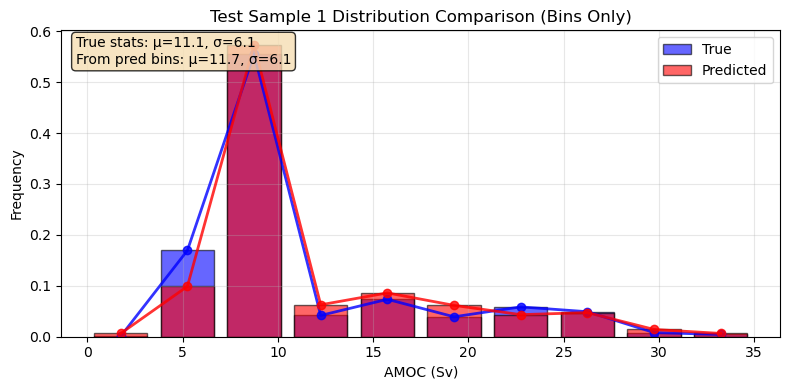

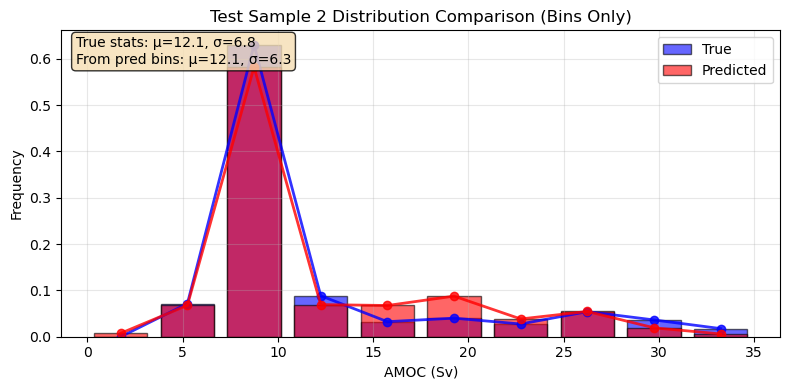

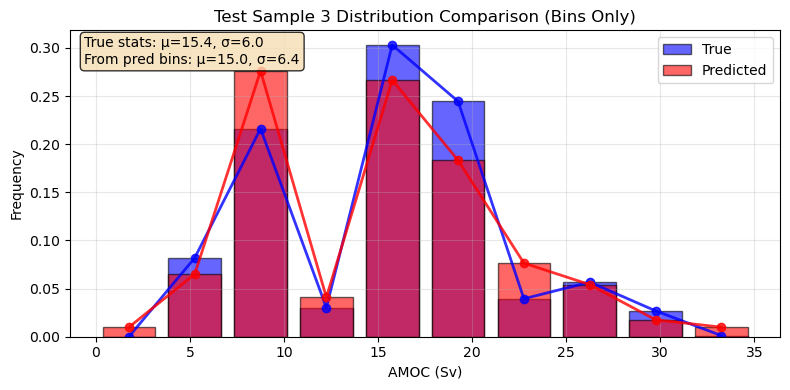

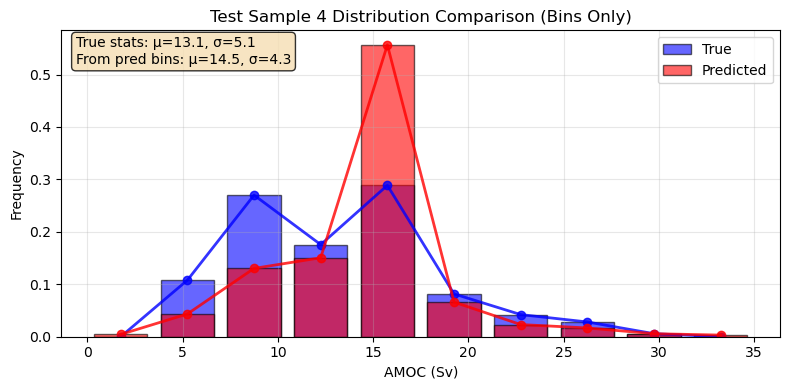

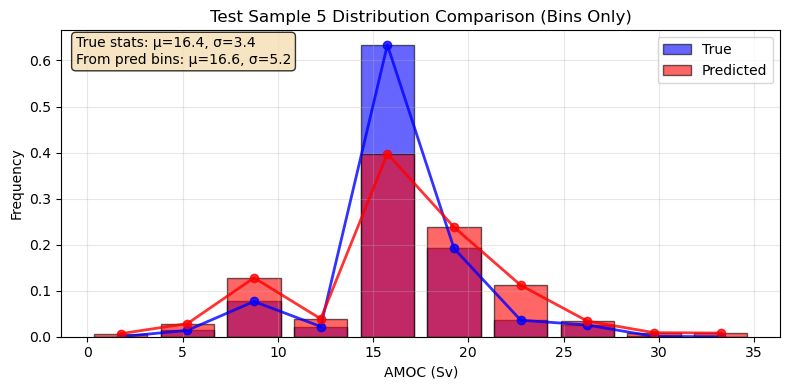

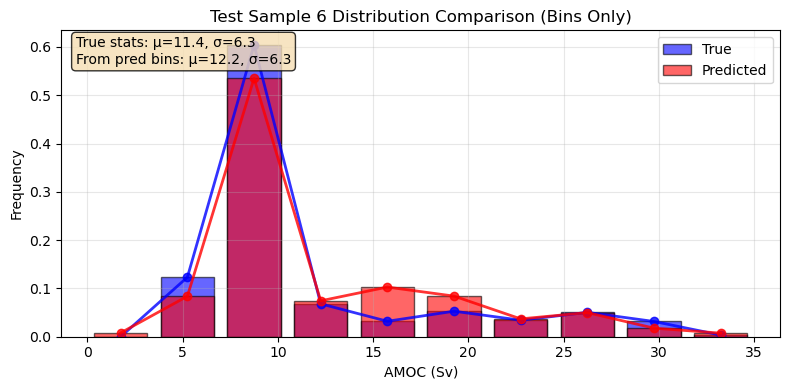

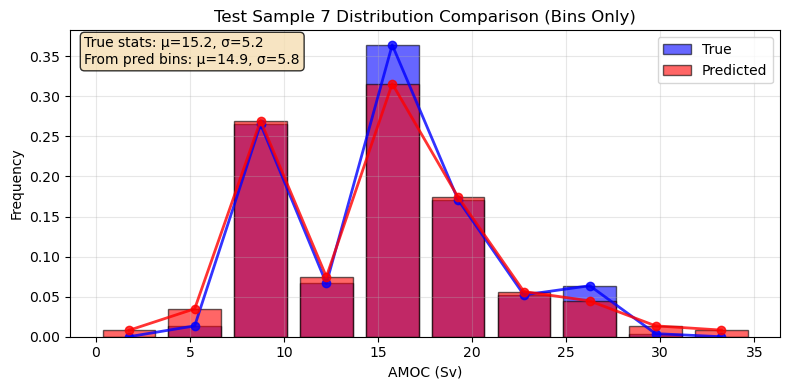

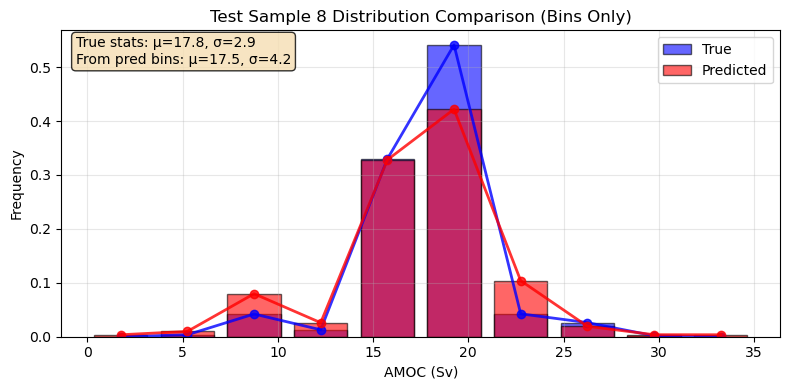

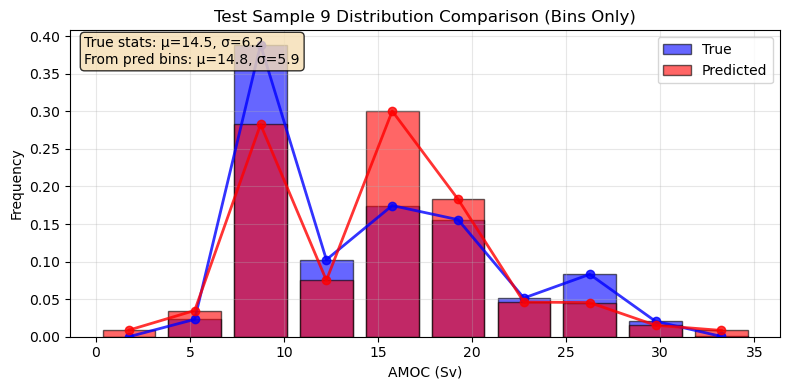

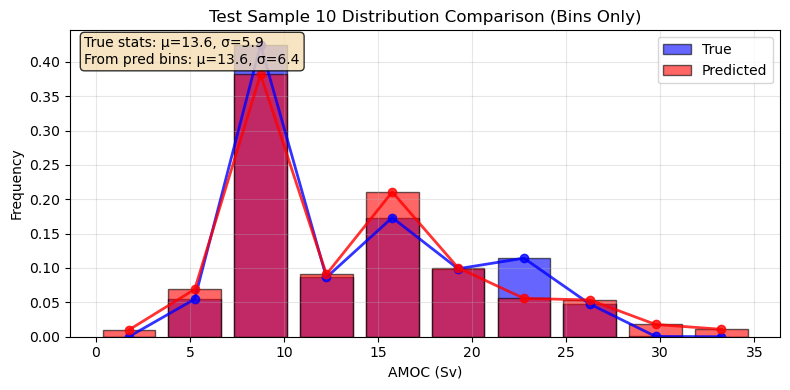


TEST PERFORMANCE (BINS ONLY)
Bin frequencies RMSE: 0.0567

Per-bin R² scores:
  Bin 1: R² = -879.906
  Bin 2: R² = 0.752
  Bin 3: R² = 0.927
  Bin 4: R² = 0.436
  Bin 5: R² = 0.627
  Bin 6: R² = 0.848
  Bin 7: R² = -0.576
  Bin 8: R² = 0.717
  Bin 9: R² = 0.464
  Bin 10: R² = -1.004

STATISTICS INFERRED FROM PREDICTED BINS
Mean - R²: 0.933, RMSE: 0.5297
Std  - R²: 0.747, RMSE: 0.7232


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# Helper function to compute stats from bins
# --------------------------------------------------
def compute_stats_from_bins(bin_frequencies, bin_centers):
    """
    Compute mean and std from bin frequencies.
    
    Parameters
    ----------
    bin_frequencies : array, shape (n_samples, n_bins)
        Normalized bin frequencies (sum to 1)
    bin_centers : array, shape (n_bins,)
        Center value of each bin
    
    Returns
    -------
    mean : array, shape (n_samples,)
    std : array, shape (n_samples,)
    """
    # Mean: weighted average
    mean = np.sum(bin_centers * bin_frequencies, axis=1)
    
    # Variance: E[X²] - E[X]²
    mean_of_squares = np.sum(bin_centers**2 * bin_frequencies, axis=1)
    variance = mean_of_squares - mean**2
    
    # Standard deviation (prevent negative variance due to numerical errors)
    std = np.sqrt(np.maximum(variance, 0))
    
    return mean, std

# --------------------------------------------------
# 1. Prepare data and split
# --------------------------------------------------
X_train, X_test, bin_train, bin_test, Y_train, Y_test = train_test_split(
    X, bin_frequencies, other_stats, test_size=0.2, random_state=42
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# --------------------------------------------------
# 2. Fit Keras NN emulator on training data (BINS ONLY)
# --------------------------------------------------
nn_emul = NNEmulatorBins(
    n_parameters=X.shape[1],
    n_bins=bin_frequencies.shape[1],
    n_other_stats=other_stats.shape[1],
    predict_stats=False,  # Bins only!
    use_softmax=True,
    n_hidden_layers=2,
    n_nodes=64,
    activation="relu",
    learning_rate=1e-3,
    l2_reg=1e-4,
    dropout_rate=0.2,
    patience=20
)
nn_emul.fit(X_train, None, bin_train, epochs=200, batch_size=8, verbose=0)
print("NN emulator fitted on training set (bins only mode).")

# --------------------------------------------------
# 3. Predict on test set
# --------------------------------------------------
bin_pred, _ = nn_emul.predict(X_test)  # Y_pred will be None

# --------------------------------------------------
# 4. Compute stats from predicted bins
# --------------------------------------------------
bins = get_amoc_bins(10)  # Get bin edges
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

# Compute stats from true and predicted bins
mean_true, std_true = compute_stats_from_bins(bin_test, bin_centers)
mean_pred, std_pred = compute_stats_from_bins(bin_pred, bin_centers)

# --------------------------------------------------
# 5. Calculate bin RMSE
# --------------------------------------------------
bin_rmse = np.sqrt(mean_squared_error(bin_test, bin_pred))
print(f"\nBin frequencies RMSE: {bin_rmse:.4f}")

# --------------------------------------------------
# 6. Compare inferred stats to true stats
# --------------------------------------------------
print("\n" + "="*40)
print("INFERRED STATISTICS FROM BINS")
print("="*40)

# Mean comparison
mean_rmse = np.sqrt(mean_squared_error(Y_test[:, 0], mean_pred))
mean_r2 = r2_score(Y_test[:, 0], mean_pred)
print(f"Mean (inferred from bins):")
print(f"  RMSE: {mean_rmse:.4f}")
print(f"  R²: {mean_r2:.4f}")

# Std comparison
std_rmse = np.sqrt(mean_squared_error(Y_test[:, 1], std_pred))
std_r2 = r2_score(Y_test[:, 1], std_pred)
print(f"\nStd (inferred from bins):")
print(f"  RMSE: {std_rmse:.4f}")
print(f"  R²: {std_r2:.4f}")

# Compare to stats computed from true bins (best case)
mean_true_from_bins, std_true_from_bins = compute_stats_from_bins(bin_test, bin_centers)
mean_recovery_error = np.mean(np.abs(Y_test[:, 0] - mean_true_from_bins))
std_recovery_error = np.mean(np.abs(Y_test[:, 1] - std_true_from_bins))

print(f"\nRecovery error (true stats vs stats from true bins):")
print(f"  Mean MAE: {mean_recovery_error:.4f}")
print(f"  Std MAE: {std_recovery_error:.4f}")
print(f"  (This shows how much info is lost in binning)")

# --------------------------------------------------
# 7. Plot test examples (limit to first 10)
# --------------------------------------------------
for i in range(min(10, len(bin_test))):
    plt.figure(figsize=(8, 4))
    
    # True vs Predicted bars
    plt.bar(bin_centers, bin_test[i], width=bin_width*0.8,
            alpha=0.6, color='blue', label='True', edgecolor='black')
    plt.bar(bin_centers, bin_pred[i], width=bin_width*0.8,
            alpha=0.6, color='red', label='Predicted', edgecolor='black')
    
    # Line plots
    plt.plot(bin_centers, bin_test[i], 'o-', color='blue',
             linewidth=2, markersize=6, alpha=0.8)
    plt.plot(bin_centers, bin_pred[i], 'o-', color='red',
             linewidth=2, markersize=6, alpha=0.8)
    
    plt.xlabel('AMOC (Sv)')
    plt.ylabel('Frequency')
    plt.title(f'Test Sample {i+1} Distribution Comparison (Bins Only)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Show true stats vs inferred stats from predicted bins
    stats_text = (
        f"True stats: μ={Y_test[i,0]:.1f}, σ={Y_test[i,1]:.1f}\n"
        f"From pred bins: μ={mean_pred[i]:.1f}, σ={std_pred[i]:.1f}"
    )
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# --------------------------------------------------
# 8. Performance summary
# --------------------------------------------------
print("\n" + "="*40)
print("TEST PERFORMANCE (BINS ONLY)")
print("="*40)

# Bin frequencies
print(f"Bin frequencies RMSE: {bin_rmse:.4f}")

# Per-bin R² (optional - shows which bins are predicted well)
print("\nPer-bin R² scores:")
for j in range(bin_test.shape[1]):
    bin_j_r2 = r2_score(bin_test[:, j], bin_pred[:, j])
    print(f"  Bin {j+1}: R² = {bin_j_r2:.3f}")

print("\n" + "="*40)
print("STATISTICS INFERRED FROM PREDICTED BINS")
print("="*40)
print(f"Mean - R²: {mean_r2:.3f}, RMSE: {mean_rmse:.4f}")
print(f"Std  - R²: {std_r2:.3f}, RMSE: {std_rmse:.4f}")


In [13]:
emulator_params = {
    'n_parameters': X.shape[1],
    'n_bins': bin_frequencies.shape[1],
    'n_other_stats': other_stats.shape[1],
    'predict_stats': False,  # NEW: Bins only mode
    'use_softmax': True,
    'n_hidden_layers': 2,
    'n_nodes': 64,
    'activation': 'relu',
    'learning_rate': 1e-3,
    'l2_reg': 1e-4,
    'dropout_rate': 0.2,
    'patience': 20
}

results = crossvalidation_bins(
    X, None, bin_frequencies,  # Pass None for other_stats
    NNEmulatorBins, 
    emulator_params=emulator_params, 
    cv=5,
    output_names=['mean', 'std', 'q25', 'q75']
)

print(f"Bins RMSE: {results['bins_rmse']:.4f}")
print(f"Bins Max Error: {results['bins_max_error']:.4f}")

print("\nPer-bin R² scores:")
for i, r2 in enumerate(results['r2_per_bin']):
    print(f"  Bin {i}: R² = {r2:.3f}")

# Note: stats results won't be available in bins-only mode
if 'stats_rmse' in results:
    print(f"\nStats RMSE: {results['stats_rmse']}")
else:
    print("\n(Statistics not predicted - bins only mode)")

Running 5-fold cross-validation...
  Fold 1: Bins RMSE=0.0552
  Fold 2: Bins RMSE=0.0456
  Fold 3: Bins RMSE=0.0333
  Fold 4: Bins RMSE=0.0557
  Fold 5: Bins RMSE=0.0716
Bins RMSE: 0.0536
Bins Max Error: 0.6401

Per-bin R² scores:
  Bin 0: R² = -5.203
  Bin 1: R² = 0.629
  Bin 2: R² = 0.938
  Bin 3: R² = 0.544
  Bin 4: R² = 0.772
  Bin 5: R² = 0.729
  Bin 6: R² = -0.135
  Bin 7: R² = 0.772
  Bin 8: R² = 0.394
  Bin 9: R² = -0.445

(Statistics not predicted - bins only mode)


# Hyperparam tuning for NN

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

class NNEmulatorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_parameters, n_bins, n_other_stats,
                 predict_stats=False, use_softmax=False,
                 n_hidden_layers=2, n_nodes=32, activation="relu",
                 learning_rate=1e-3, l2_reg=1e-4, dropout_rate=0.2,
                 patience=20, epochs=100, batch_size=8, verbose=0):
        """
        Sklearn-compatible wrapper for NNEmulatorBins.
        
        Parameters
        ----------
        predict_stats : bool, default=False
            If True, predict both bins and stats. If False, only predict bins.
        use_softmax : bool, default=False
            If True, use softmax for bins (only valid with predict_stats=False).
        """
        self.n_parameters = n_parameters
        self.n_bins = n_bins
        self.n_other_stats = n_other_stats
        self.predict_stats = predict_stats
        self.use_softmax = use_softmax
        self.n_hidden_layers = n_hidden_layers
        self.n_nodes = n_nodes
        self.activation = activation
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.patience = patience
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_ = None
    
    def fit(self, X, y):
        """
        Fit the model.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_parameters)
        y : array-like, shape (n_samples, n_other_stats + n_bins)
            If predict_stats=True: concatenated [other_stats, bin_frequencies]
            If predict_stats=False: just bin_frequencies (but must match expected shape)
        """
        if self.predict_stats:
            # Split y into stats and bins
            Y = y[:, :self.n_other_stats]
            bin_frequencies = y[:, self.n_other_stats:]
        else:
            # y contains only bins (but might be passed with stats for compatibility)
            if y.shape[1] == self.n_bins:
                # Only bins provided
                Y = None
                bin_frequencies = y
            else:
                # Stats + bins provided, but we ignore stats
                Y = None
                bin_frequencies = y[:, self.n_other_stats:]
        
        # Create model
        self.model_ = NNEmulatorBins(
            n_parameters=self.n_parameters,
            n_bins=self.n_bins,
            n_other_stats=self.n_other_stats,
            predict_stats=self.predict_stats,
            use_softmax=self.use_softmax,
            n_hidden_layers=self.n_hidden_layers,
            n_nodes=self.n_nodes,
            activation=self.activation,
            learning_rate=self.learning_rate,
            l2_reg=self.l2_reg,
            dropout_rate=self.dropout_rate,
            patience=self.patience
        )
        
        # Fit model
        self.model_.fit(
            X, Y, bin_frequencies,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose
        )
        return self
    
    def predict(self, X):
        """
        Predict and return concatenated output.
        
        Returns
        -------
        y_pred : array-like
            If predict_stats=True: shape (n_samples, n_other_stats + n_bins)
            If predict_stats=False: shape (n_samples, n_bins)
        """
        if self.model_ is None:
            raise RuntimeError("Model not fitted yet.")
        
        bin_pred, Y_pred = self.model_.predict(X)
        
        if self.predict_stats:
            # Return concatenated [stats, bins]
            return np.hstack([Y_pred, bin_pred])
        else:
            # Return only bins
            return bin_pred

    def score(self, X, y):
            """
            Combined score for NN: balances bins and other summary stats.
            Higher is better for GridSearchCV.
            
            Returns negative mean RMSE of bins (weighted by alpha if multi-task).
            """
            if self.model_ is None:
                raise RuntimeError("Model not fitted yet.")
            
            bin_pred, Y_pred = self.model_.predict(X)
            
            # Extract true values
            if y.shape[1] == self.n_bins:
                # Only bins in y
                bin_frequencies = y
                Y = None
            else:
                # y contains stats + bins
                Y = y[:, :self.n_other_stats]
                bin_frequencies = y[:, self.n_other_stats:]
            
            # Normalize RMSE per feature for bins
            rmse_bins = np.sqrt(np.mean((bin_frequencies - bin_pred)**2, axis=0))
            rmse_bins_norm = rmse_bins / (np.std(bin_frequencies, axis=0) + 1e-12)
            rmse_bins_score = 1 - np.mean(rmse_bins_norm)
            
            if self.predict_stats and Y_pred is not None and Y is not None:
                # Normalize RMSE per feature for stats
                rmse_stats = np.sqrt(np.mean((Y - Y_pred)**2, axis=0))
                rmse_stats_norm = rmse_stats / (np.std(Y, axis=0) + 1e-12)
                rmse_stats_score = 1 - np.mean(rmse_stats_norm)
                
                # Combine scores
                combined_score = self.alpha * rmse_bins_score + (1 - self.alpha) * rmse_stats_score
                
                # Return negative mean RMSE (for minimization)
                # You can also return combined_score for maximization
                return -np.mean(rmse_bins)  # or return combined_score
            else:
                # Bins only - return negative mean RMSE
                return -np.mean(rmse_bins)
    


In [15]:
param_grid = {
    'n_hidden_layers': [1, 2, 3],
    'n_nodes': [16, 32, 64],
    'activation': ['relu'],# 'tanh'],
    #'learning_rate': [1e-4, 1e-3, 5e-3],
    #'dropout_rate': [0.0, 0.2, 0.5],
    #'l2_reg': [1e-5, 1e-4, 1e-3],
}


In [16]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

tune = False

if tune: 
    # For bins-only mode, use only bin_frequencies
    y_data = bin_frequencies  # Just bins for bins-only mode
    
    # If you want to test multi-task, uncomment this instead:
    # y_data = np.hstack((other_stats, bin_frequencies))
    
    nn_wrapper = NNEmulatorWrapper(
        n_parameters=X.shape[1],
        n_bins=bin_frequencies.shape[1],
        n_other_stats=other_stats.shape[1],
        predict_stats=False,  # NEW: Bins only
        use_softmax=True,     # NEW: Use softmax
        epochs=200,
        batch_size=8,
        verbose=0
    )
    
    grid_search = GridSearchCV(
        estimator=nn_wrapper,
        param_grid=param_grid,
        scoring=None,     # Uses the score() method (R² for bins)
        cv=3,
        verbose=2,
        n_jobs=1          # Must be 1 because Keras doesn't like parallel jobs
    )
    
    grid_search.fit(X, y_data)
    
    print("\n" + "=" * 70)
    print("BEST PARAMETERS (BINS-ONLY WITH SOFTMAX):")
    print("=" * 70)
    for key, val in grid_search.best_params_.items():
        print(f"  {key}: {val}")
    
    best_score = grid_search.best_score_
    print(f"\nBest R² Score: {best_score:.6f}")
    
    # --- Detailed results ---
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = results_df.sort_values('rank_test_score')
    
    print("\nTop 5 configurations:")
    for i, (idx, row) in enumerate(results_df.head(5).iterrows(), 1):
        print(f"\n{i}. Params: {row['params']}")
        print(f"   Mean R² Score: {row['mean_test_score']:.6f}")
        print(f"   Std Score: {row['std_test_score']:.6f}")
    
    # Save best model
    best_model = grid_search.best_estimator_

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
import numpy as np
import pandas as pd

# --------------------------------------------------
# Parameter distributions for random search
# --------------------------------------------------
param_distributions = {
    'n_hidden_layers': [1, 2, 3],
    'n_nodes': [16, 32, 64, 128],
    'activation': ['relu', 'leaky_relu'],
    'learning_rate': loguniform(1e-4, 1e-2),
    'dropout_rate': uniform(0.0, 0.5),
    'l2_reg': loguniform(1e-6, 1e-3),
}

# --------------------------------------------------
# Prepare data for bins-only mode
# --------------------------------------------------
y_data = bin_frequencies  # Just bins for bins-only mode

tune = False

if tune: 
    nn_wrapper = NNEmulatorWrapper(
        n_parameters=X.shape[1],
        n_bins=bin_frequencies.shape[1],
        n_other_stats=other_stats.shape[1],
        predict_stats=False,  # Bins only
        use_softmax=True,     # Use softmax
        epochs=200,
        batch_size=8,
        verbose=0
    )
    
    # --------------------------------------------------
    # Randomized Search setup
    # --------------------------------------------------
    random_search = RandomizedSearchCV(
        estimator=nn_wrapper,
        param_distributions=param_distributions,
        n_iter=20,
        scoring=None,
        cv=5,
        verbose=2,
        n_jobs=1,
        random_state=42
    )
    
    # --------------------------------------------------
    # Run search
    # --------------------------------------------------
    random_search.fit(X, y_data)
    
    # --------------------------------------------------
    # Results summary
    # --------------------------------------------------
    print("\n" + "=" * 70)
    print("BEST PARAMETERS:")
    for key, val in random_search.best_params_.items():
        print(f"  {key}: {val}")
    
    best_score = random_search.best_score_
    print(f"\nBest Score: {best_score:.6f}")
    if best_score < 0:
        print(f"Best RMSE: {-best_score:.6f}")
    
    # --- Detailed results ---
    results_df = pd.DataFrame(random_search.cv_results_)
    results_df = results_df.sort_values('rank_test_score')
    
    print("\nTop 5 configurations:")
    for i, (idx, row) in enumerate(results_df.head(5).iterrows(), 1):
        print(f"{i}. Params: {row['params']}")
        print(f"   Mean Score: {row['mean_test_score']:.6f}")
        if row['mean_test_score'] < 0:
            print(f"   RMSE: {-row['mean_test_score']:.6f}")
        print(f"   Std Score: {row['std_test_score']:.6f}")

In [18]:
if tune:

    # Extract top 5 performing parameter sets
    top5_df = results_df.head(5)[['params', 'mean_test_score', 'std_test_score']]
    
    # Save the params separately as JSON
    top5_params = top5_df['params'].tolist()
    
    with open('top5_params.json', 'w') as f:
        json.dump(top5_params, f, indent=2)
    
    # Optionally also save scores in a CSV for inspection
    top5_df.drop(columns='params').to_csv('top5_scores.csv', index=False)
    
    print("✅ Saved:")
    print(" - top5_params.json (parameter sets)")
    print(" - top5_scores.csv (scores only)")



In [19]:
with open('top5_params.json', 'r') as f:
    top5_params = json.load(f)

model_1 = NNEmulatorBins(
    n_parameters=X.shape[1],
    n_bins=bin_frequencies.shape[1],
    n_other_stats=other_stats.shape[1],
    predict_stats=False,  # Bins only!
    use_softmax=True,
    **top5_params[0]  # best config
)

model_2 = NNEmulatorBins(
    n_parameters=X.shape[1],
    n_bins=bin_frequencies.shape[1],
    n_other_stats=other_stats.shape[1],
    predict_stats=False,  # Bins only!
    use_softmax=True,
    **top5_params[1]  # 2nd best config
)

model_3 = NNEmulatorBins(
    n_parameters=X.shape[1],
    n_bins=bin_frequencies.shape[1],
    n_other_stats=other_stats.shape[1],
    predict_stats=False,  # Bins only!
    use_softmax=True,
    **top5_params[2]  # 2nd best config
)

Train size: 79, Test size: 20
NN emulator fitted on training set (bins only mode).

Bin frequencies RMSE: 0.0285

INFERRED STATISTICS FROM BINS
Mean (inferred from bins):
  RMSE: 0.4514
  R²: 0.9629

Std (inferred from bins):
  RMSE: 0.8822
  R²: 0.7619

Recovery error (true stats vs stats from true bins):
  Mean MAE: 0.1902
  Std MAE: 0.1073
  (This shows how much info is lost in binning)


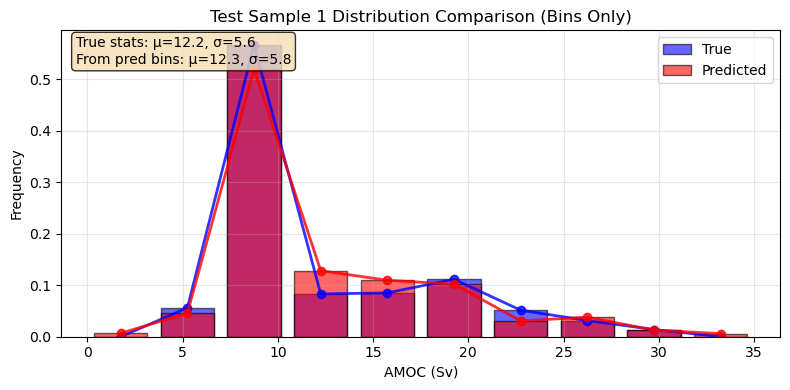

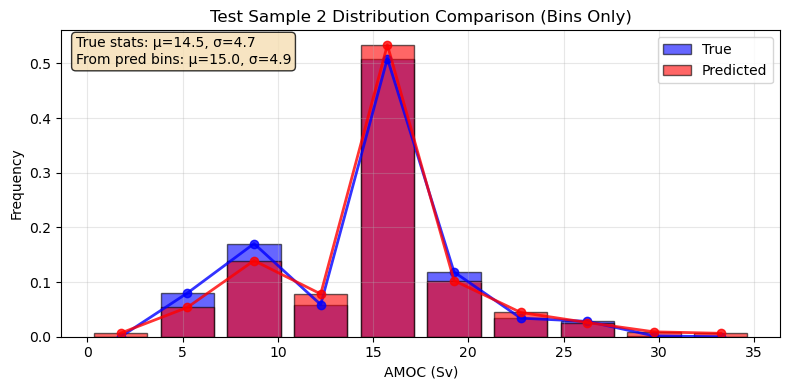

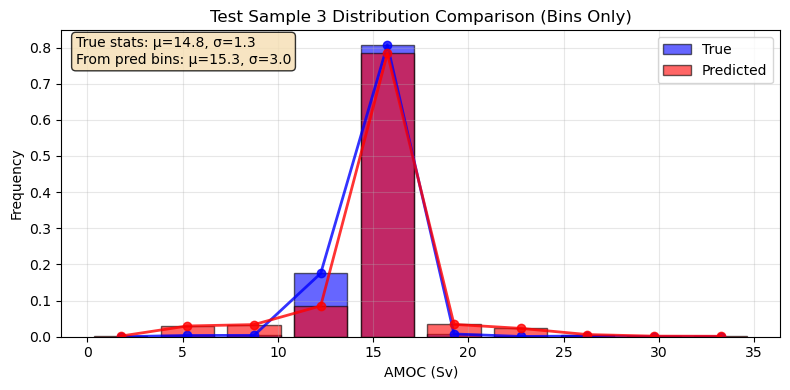

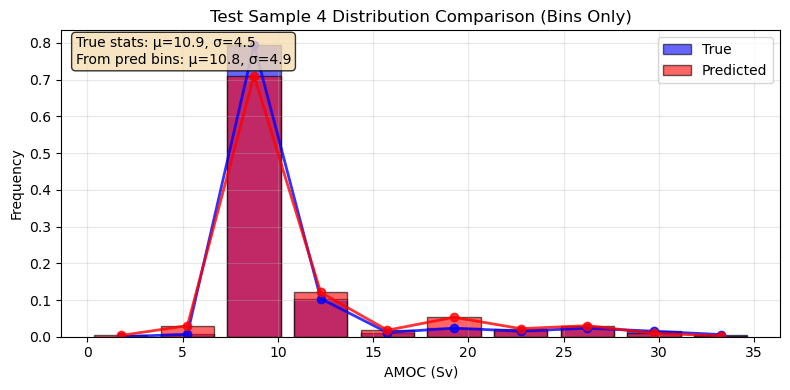

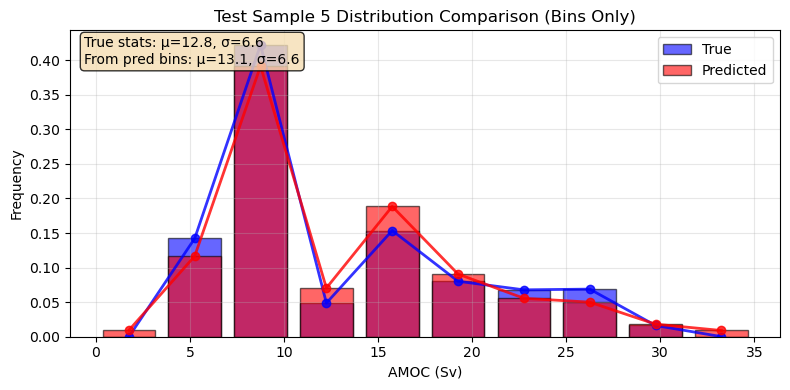

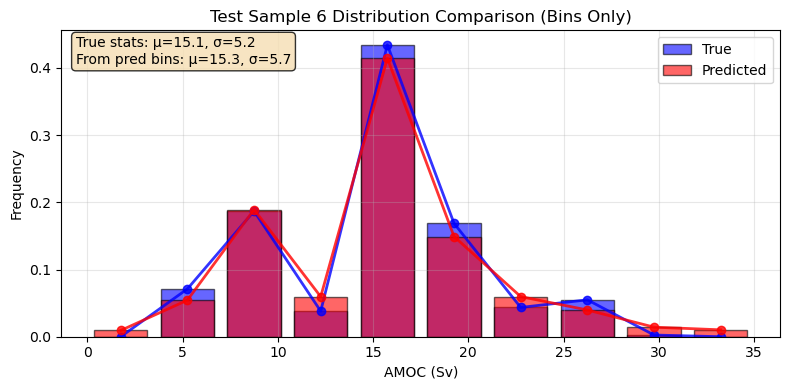

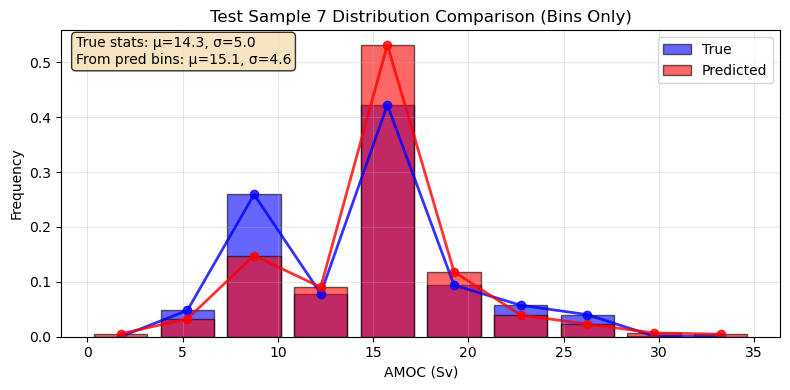

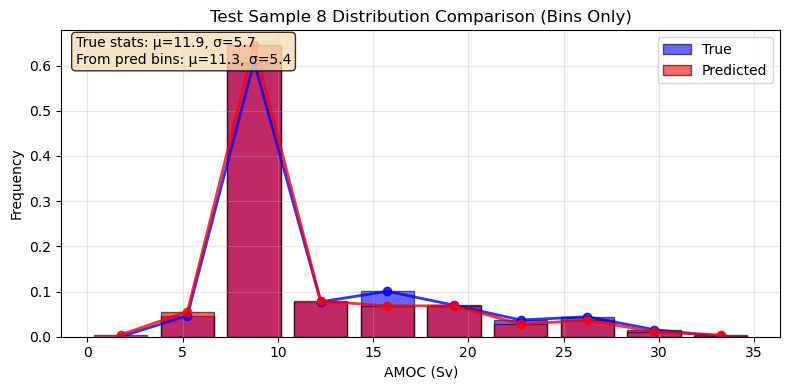

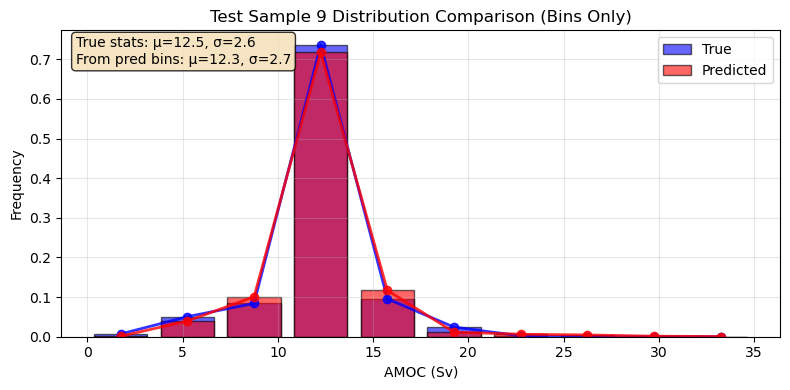

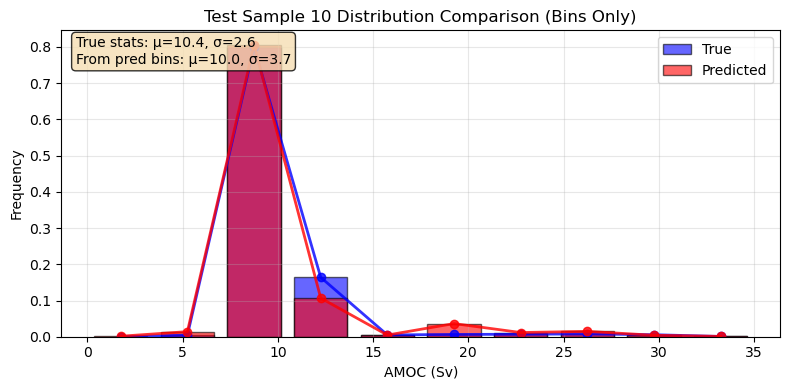


TEST PERFORMANCE (BINS ONLY)
Bin frequencies RMSE: 0.0285

Per-bin R² scores:
  Bin 1: R² = -14.081
  Bin 2: R² = 0.697
  Bin 3: R² = 0.972
  Bin 4: R² = 0.940
  Bin 5: R² = 0.977
  Bin 6: R² = 0.907
  Bin 7: R² = 0.409
  Bin 8: R² = 0.818
  Bin 9: R² = 0.432
  Bin 10: R² = -2.999

STATISTICS INFERRED FROM PREDICTED BINS
Mean - R²: 0.963, RMSE: 0.4514
Std  - R²: 0.762, RMSE: 0.8822


In [20]:
X_train, X_test, bin_train, bin_test, Y_train, Y_test = train_test_split(
    X, bin_frequencies, other_stats, test_size=0.2, random_state=43
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

model_1.fit(X_train, None, bin_train, epochs=300, batch_size=8, verbose=0)
print("NN emulator fitted on training set (bins only mode).")

# --------------------------------------------------
# 3. Predict on test set
# --------------------------------------------------
bin_pred, _ = nn_emul.predict(X_test)  # Y_pred will be None

# --------------------------------------------------
# 4. Compute stats from predicted bins
# --------------------------------------------------
bins = get_amoc_bins(10)  # Get bin edges
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

# Compute stats from true and predicted bins
mean_true, std_true = compute_stats_from_bins(bin_test, bin_centers)
mean_pred, std_pred = compute_stats_from_bins(bin_pred, bin_centers)

# --------------------------------------------------
# 5. Calculate bin RMSE
# --------------------------------------------------
bin_rmse = np.sqrt(mean_squared_error(bin_test, bin_pred))
print(f"\nBin frequencies RMSE: {bin_rmse:.4f}")

# --------------------------------------------------
# 6. Compare inferred stats to true stats
# --------------------------------------------------
print("\n" + "="*40)
print("INFERRED STATISTICS FROM BINS")
print("="*40)

# Mean comparison
mean_rmse = np.sqrt(mean_squared_error(Y_test[:, 0], mean_pred))
mean_r2 = r2_score(Y_test[:, 0], mean_pred)
print(f"Mean (inferred from bins):")
print(f"  RMSE: {mean_rmse:.4f}")
print(f"  R²: {mean_r2:.4f}")

# Std comparison
std_rmse = np.sqrt(mean_squared_error(Y_test[:, 1], std_pred))
std_r2 = r2_score(Y_test[:, 1], std_pred)
print(f"\nStd (inferred from bins):")
print(f"  RMSE: {std_rmse:.4f}")
print(f"  R²: {std_r2:.4f}")

# Compare to stats computed from true bins (best case)
mean_true_from_bins, std_true_from_bins = compute_stats_from_bins(bin_test, bin_centers)
mean_recovery_error = np.mean(np.abs(Y_test[:, 0] - mean_true_from_bins))
std_recovery_error = np.mean(np.abs(Y_test[:, 1] - std_true_from_bins))

print(f"\nRecovery error (true stats vs stats from true bins):")
print(f"  Mean MAE: {mean_recovery_error:.4f}")
print(f"  Std MAE: {std_recovery_error:.4f}")
print(f"  (This shows how much info is lost in binning)")

# --------------------------------------------------
# 7. Plot test examples (limit to first 10)
# --------------------------------------------------
for i in range(min(10, len(bin_test))):
    plt.figure(figsize=(8, 4))
    
    # True vs Predicted bars
    plt.bar(bin_centers, bin_test[i], width=bin_width*0.8,
            alpha=0.6, color='blue', label='True', edgecolor='black')
    plt.bar(bin_centers, bin_pred[i], width=bin_width*0.8,
            alpha=0.6, color='red', label='Predicted', edgecolor='black')
    
    # Line plots
    plt.plot(bin_centers, bin_test[i], 'o-', color='blue',
             linewidth=2, markersize=6, alpha=0.8)
    plt.plot(bin_centers, bin_pred[i], 'o-', color='red',
             linewidth=2, markersize=6, alpha=0.8)
    
    plt.xlabel('AMOC (Sv)')
    plt.ylabel('Frequency')
    plt.title(f'Test Sample {i+1} Distribution Comparison (Bins Only)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Show true stats vs inferred stats from predicted bins
    stats_text = (
        f"True stats: μ={Y_test[i,0]:.1f}, σ={Y_test[i,1]:.1f}\n"
        f"From pred bins: μ={mean_pred[i]:.1f}, σ={std_pred[i]:.1f}"
    )
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# --------------------------------------------------
# 8. Performance summary
# --------------------------------------------------
print("\n" + "="*40)
print("TEST PERFORMANCE (BINS ONLY)")
print("="*40)

# Bin frequencies
print(f"Bin frequencies RMSE: {bin_rmse:.4f}")

# Per-bin R² (optional - shows which bins are predicted well)
print("\nPer-bin R² scores:")
for j in range(bin_test.shape[1]):
    bin_j_r2 = r2_score(bin_test[:, j], bin_pred[:, j])
    print(f"  Bin {j+1}: R² = {bin_j_r2:.3f}")

print("\n" + "="*40)
print("STATISTICS INFERRED FROM PREDICTED BINS")
print("="*40)
print(f"Mean - R²: {mean_r2:.3f}, RMSE: {mean_rmse:.4f}")
print(f"Std  - R²: {std_r2:.3f}, RMSE: {std_rmse:.4f}")


In [21]:
import numpy as np

# Shared architecture parameters (fixed for all models)
base_params = {
    'n_parameters': X.shape[1],
    'n_bins': bin_frequencies.shape[1],
    'n_other_stats': other_stats.shape[1],
}

# Loop through top 2 parameter sets
for i, params in enumerate(top5_params[:3], start=1):
    emulator_params = {**base_params, **params}

    print(f"\n=== Model {i} ===")
    for k, v in params.items():
        print(f"{k}: {v}")

    results = crossvalidation_bins(
        X, other_stats, bin_frequencies,
        NNEmulatorBins,
        emulator_params=emulator_params,
        cv=5,
        output_names=['mean', 'std', 'q25', 'q75']
    )

    print(f"\nModel {i} Results:")
    print(f"  RMSE: {results['bins_rmse']:.4f}")
    print(f"  Max Error: {results['bins_max_error']:.4f}")
    print(f"  Mean R²: {np.mean(results['r2_per_bin']):.3f}")
    print(results['r2_per_bin'])



=== Model 1 ===
activation: relu
dropout_rate: 0.30919300466654365
l2_reg: 1.4040609919104435e-05
learning_rate: 0.009256818992066877
n_hidden_layers: 1
n_nodes: 64
Running 5-fold cross-validation...
  Fold 1: Bins RMSE=0.0539, Stats RMSE=1.1856
  Fold 2: Bins RMSE=0.0492, Stats RMSE=1.2947
  Fold 3: Bins RMSE=0.0452, Stats RMSE=1.1112
  Fold 4: Bins RMSE=0.0674, Stats RMSE=1.4224
  Fold 5: Bins RMSE=0.0710, Stats RMSE=1.3207

Model 1 Results:
  RMSE: 0.0581
  Max Error: 0.5546
  Mean R²: 0.526
[-0.4508256247324318, 0.6397403916586244, 0.8885547599709314, 0.6501726369747791, 0.7005575479712607, 0.8410138827293041, -0.0007715995190031855, 0.7115032075247594, 0.6932271471245492, 0.5905378606044289]

=== Model 2 ===
activation: relu
dropout_rate: 0.36480308916903204
l2_reg: 8.178476574339548e-05
learning_rate: 0.0059487468132197715
n_hidden_layers: 1
n_nodes: 64
Running 5-fold cross-validation...
  Fold 1: Bins RMSE=0.0547, Stats RMSE=1.2308
  Fold 2: Bins RMSE=0.0511, Stats RMSE=1.2918


# Gradient based parameter estimation

In [22]:
prior_bounds = {
    "diff_dia_min": (7.5e-6, 1.25e-5),
    "drag_topo_fac": (2.25, 3.75),
    "slope_max": (7.5e-4, 1.25e-3),
    "diff_iso": (1125, 1875),
    "diff_gm": (1125, 1875),
    "diff_dia_max": (1.125e-4, 1.875e-4),
}
# ----------------------------------------
# 1. Prepare observed (target) summaries
# ----------------------------------------
bins_default = default_stats['bin_frequencies']  # shape (n_bins,)
stats_default = np.array([
    default_stats['mean'],
    default_stats['std'],
    default_stats['q25'],
    default_stats['q75']
])

# Combine both into one target vector (same as emulator output)
y_target = np.concatenate([bins_default, stats_default])

# ----------------------------------------
# 2. Convert prior bounds to list of tuples
# ----------------------------------------
param_names = list(prior_bounds.keys())
bounds = [prior_bounds[name] for name in param_names]
n_parameters = len(param_names)

# ----------------------------------------
# 3. Initialize emulator (after training)
# ----------------------------------------
model_1 = NNEmulatorBins(
    n_parameters=X.shape[1],
    n_bins=bin_frequencies.shape[1],
    n_other_stats=other_stats.shape[1],
    **top5_params[0]  # best config
)

model_1.fit(X, other_stats, bin_frequencies)

model_2 = NNEmulatorBins(
    n_parameters=X.shape[1],
    n_bins=bin_frequencies.shape[1],
    n_other_stats=other_stats.shape[1],
    **top5_params[1]  # 2nd best config
)
model_2.fit(X, other_stats, bin_frequencies)

model_3 = NNEmulatorBins(
    n_parameters=X.shape[1],
    n_bins=bin_frequencies.shape[1],
    n_other_stats=other_stats.shape[1],
    **top5_params[2]  # 2nd best config
)
model_3.fit(X, other_stats, bin_frequencies)

# (Assuming you’ve already trained the emulator)
#emu = NNEmulatorBins(
#    n_parameters=n_parameters,
#    n_bins=len(bins_default),
#    n_other_stats=len(stats_default)
#)
#emu.fit(X_train, Y_train, bin_train)

# ----------------------------------------
# 4. Calibrate using gradient descent
# ----------------------------------------
theta_opt, final_loss = model_3.calibrate(
    y_target=y_target,
    bounds=bounds,
    n_iter=2000,
    lr=5e-3,
    verbose=True
)

# ----------------------------------------
# 5. Inspect calibrated parameters
# ----------------------------------------
calibrated_params = dict(zip(param_names, theta_opt.flatten()))
print("Calibrated parameters:")
for k, v in calibrated_params.items():
    print(f"{k:15s} = {v:.6g}")
print(f"Final loss = {final_loss:.4g}")

theta_opt, final_loss = model_1.calibrate_max(
    y_target=y_target,
    bounds=bounds,
    max_iter=5000,
    lr=5e-3,
    verbose=True
)

calibrated_params = dict(zip(param_names, theta_opt.flatten()))
print("Calibrated parameters:")
for k, v in calibrated_params.items():
    print(f"{k:15s} = {v:.6g}")
print(f"Final loss = {final_loss:.4g}")



Iter 0000 | Loss: 0.583437
Iter 0050 | Loss: 0.228344
Iter 0100 | Loss: 0.097000
Iter 0150 | Loss: 0.062009
Iter 0200 | Loss: 0.052539
Iter 0250 | Loss: 0.047959
Iter 0300 | Loss: 0.045458
Iter 0350 | Loss: 0.043310
Iter 0400 | Loss: 0.041345
Iter 0450 | Loss: 0.039382
Iter 0500 | Loss: 0.037313
Iter 0550 | Loss: 0.035648
Iter 0600 | Loss: 0.034316
Iter 0650 | Loss: 0.033210
Iter 0700 | Loss: 0.032244
Iter 0750 | Loss: 0.031388
Iter 0800 | Loss: 0.030630
Iter 0850 | Loss: 0.029964
Iter 0900 | Loss: 0.029381
Iter 0950 | Loss: 0.028869
Iter 1000 | Loss: 0.028300
Iter 1050 | Loss: 0.027886
Iter 1100 | Loss: 0.027592
Iter 1150 | Loss: 0.027381
Iter 1200 | Loss: 0.027227
Iter 1250 | Loss: 0.027113
Iter 1300 | Loss: 0.027024
Iter 1350 | Loss: 0.026952
Iter 1400 | Loss: 0.026892
Iter 1450 | Loss: 0.026839
Iter 1500 | Loss: 0.026791
Iter 1550 | Loss: 0.026745
Iter 1600 | Loss: 0.026702
Iter 1650 | Loss: 0.026660
Iter 1700 | Loss: 0.026619
Iter 1750 | Loss: 0.026579
Iter 1800 | Loss: 0.026540
I

In [23]:
n_starts = 200
solutions = []

run_grad_opt=True
if run_grad_opt:

    for i in range(n_starts):
        print("iteration ", i)
        theta_opt, loss = model_1.calibrate_max(
            y_target=y_target,
            bounds=[prior_bounds[k] for k in prior_bounds],
            tol=0.01/2,
            max_iter=3000,
            lr=5e-3,
            verbose=False
        )
        solutions.append((theta_opt.flatten(), loss))
    
    # Sort solutions by loss
    solutions.sort(key=lambda x: x[1])
    best_solutions = solutions[:5]
    
    for i, (theta, loss) in enumerate(best_solutions):
        print(f"Optimum {i}: loss={loss:.6f}, theta={theta}")


iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
it

In [24]:
accepted_params_grad = np.array([sol[0] for sol in solutions])
np.save('optimal_params_nn.npy', accepted_params_grad)
#accepted_params = np.load('optimal_params_nn.npy')
print(accepted_params_grad[:10])

[[8.0102645e-06 2.9021637e+00 1.2189148e-03 1.4599540e+03 1.4911664e+03
  1.7578737e-04]
 [9.0502963e-06 3.2712891e+00 1.1716147e-03 1.7436515e+03 1.4587743e+03
  1.6312949e-04]
 [8.2630613e-06 3.0280719e+00 1.2016402e-03 1.5577487e+03 1.4413599e+03
  1.6991851e-04]
 [7.9921392e-06 3.0069590e+00 1.1434978e-03 1.5378167e+03 1.4646177e+03
  1.7254683e-04]
 [8.0816098e-06 2.9572387e+00 1.2047392e-03 1.5352462e+03 1.4493481e+03
  1.6848290e-04]
 [8.4390040e-06 3.1721494e+00 1.2172897e-03 1.5748309e+03 1.2783186e+03
  1.6484263e-04]
 [8.1759226e-06 3.0199828e+00 1.1915587e-03 1.5507716e+03 1.4916147e+03
  1.7385153e-04]
 [8.1470907e-06 3.0387895e+00 1.1566934e-03 1.5764827e+03 1.4500068e+03
  1.6908094e-04]
 [8.3231107e-06 3.1027644e+00 1.1972686e-03 1.5819200e+03 1.3837570e+03
  1.6808748e-04]
 [7.9693200e-06 2.8994761e+00 1.2046676e-03 1.4632328e+03 1.4839773e+03
  1.7487540e-04]]


In [25]:
# Parameter names in the correct order
param_names = ["ocn.diff_dia_min", "ocn.drag_topo_fac", "ocn.slope_max",
               "ocn.diff_iso", "ocn.diff_gm", "ocn.diff_dia_max"]

# Randomly select 50 accepted parameter sets (without replacement)
n_save = min(50, len(accepted_params_grad))
#random_idx = np.random.choice(len(accepted_params), size=n_save, replace=False)
chosen_params = accepted_params_grad[:n_save]

# Save to text file
out_file = "chosen_params_nn.txt"
with open(out_file, "w") as f:
    # Write header
    f.write(" ".join(param_names) + "\n")
    # Write parameter rows
    for row in chosen_params:
        f.write(" ".join(f"{val:.17g}" for val in row) + "\n")

print(f"Saved {n_save} parameter sets to {out_file}")


Saved 50 parameter sets to chosen_params_nn.txt


/tmp/ipykernel_4113450/4259833804.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(best_thetas))


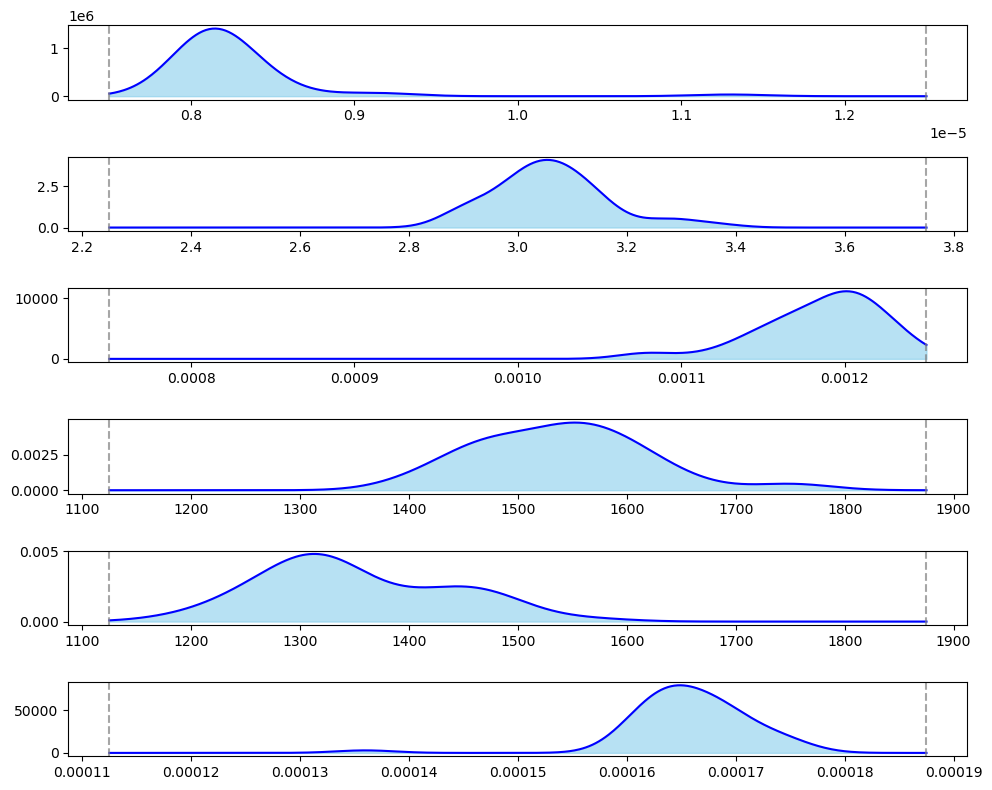

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

accepted = np.array(accepted_params_grad[:50])  # (n_sets, n_params)
n_params = len(param_names)
best_thetas = accepted_params_grad  # (n_best, n_params)

# Define a colormap — e.g., 'tab10' (distinct colors)
colors = cm.get_cmap('tab10', len(best_thetas))

fig, axes = plt.subplots(n_params, 1, figsize=(10, 8), sharex=False)

for j, ax in enumerate(axes):
    lb, ub = bounds[j]
    data = accepted[:, j]

    # KDE from accepted samples
    kde = gaussian_kde(data)
    x_vals = np.linspace(lb, ub, 500)
    y_vals = kde(x_vals)

    ax.fill_between(x_vals, 0, y_vals, color='skyblue', alpha=0.6)
    ax.plot(x_vals, y_vals, color='blue', label='Accepted samples')

    # Prior bounds
    ax.axvline(lb, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(ub, color='gray', linestyle='--', alpha=0.7)

    # Optimization-based estimates: each solution = one color
    #for i, theta in enumerate(best_thetas):
    #    ax.axvline(theta[j], color=colors(i), linestyle='-', linewidth=2, alpha=0.9,
    #              label=f'Optimum {i+1}' if j == 0 else None)  # only label on first subplot

    #ax.set_xlim(lb, ub)
    #ax.set_ylabel(param_names[j], rotation=0, ha='right', va='center')
    #ax.yaxis.set_label_coords(-0.02, 0.5)
    #ax.set_yticks([])
    #ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


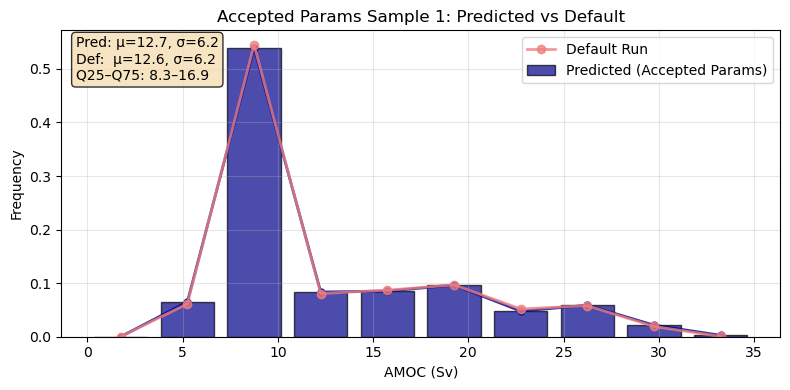

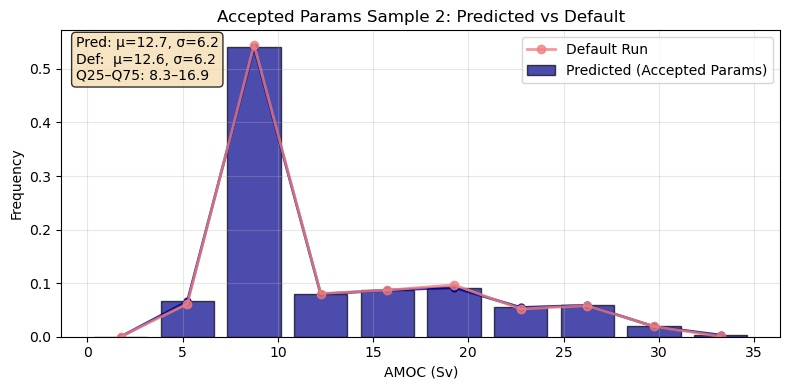

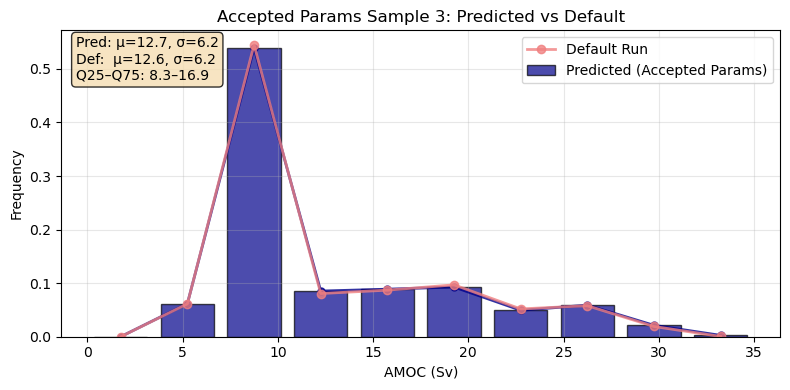

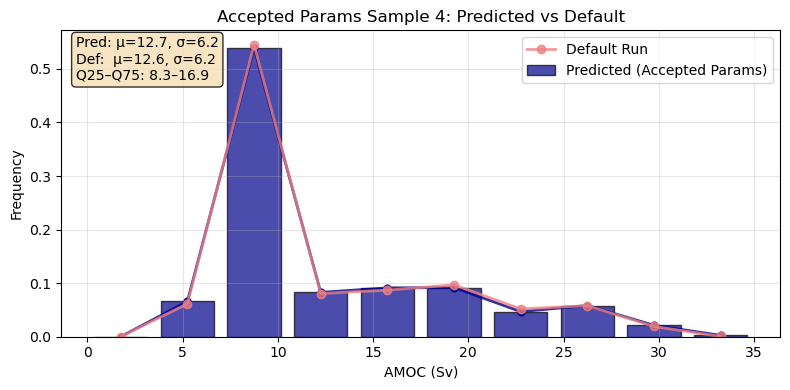

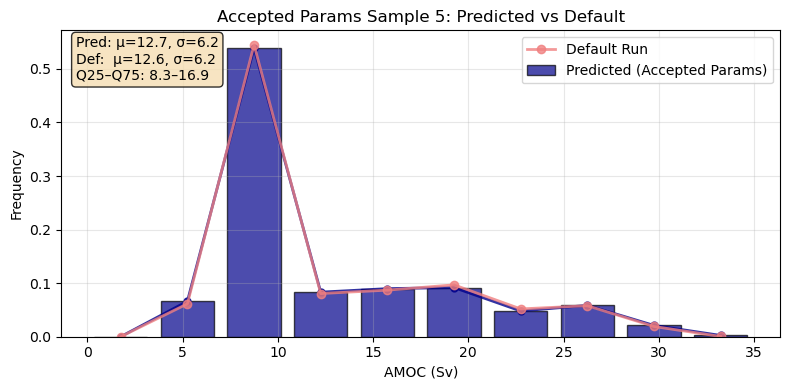

In [27]:
# --------------------------------------------------
# Predict on accepted_params
# --------------------------------------------------
bin_pred_acc, Y_pred_acc = model_1.predict(accepted_params_grad)

# --------------------------------------------------
# Plot predictions vs default reference
# --------------------------------------------------
bins = get_amoc_bins(10)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

for i in range(min(5, len(bin_pred_acc))):
    plt.figure(figsize=(8, 4))

    # --- Predicted distribution (Accepted Params) ---
    plt.bar(
        bin_centers, bin_pred_acc[i],
        width=bin_width * 0.8, alpha=0.7,
        color='darkblue', edgecolor='black',
        label='Predicted (Accepted Params)'
    )
    plt.plot(
        bin_centers, bin_pred_acc[i],
        'o-', color='darkblue', linewidth=2, markersize=5, alpha=0.8
    )

    # --- Default run distribution (from default['bin_frequencies']) ---
    plt.plot(
        bin_centers, default_stats['bin_frequencies'],
        'o-', color='lightcoral', linewidth=2, alpha=0.8,
        label='Default Run'
    )

    # Labels and legend
    plt.xlabel('AMOC (Sv)')
    plt.ylabel('Frequency')
    plt.title(f'Accepted Params Sample {i+1}: Predicted vs Default')
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Statistics text box (Predicted + Default) ---
    stats_text = (
        f"Pred: μ={Y_pred_acc[i,0]:.1f}, σ={Y_pred_acc[i,1]:.1f}\n"
        f"Def:  μ={default_stats['mean']:.1f}, σ={default_stats['std']:.1f}\n"
        f"Q25–Q75: {default_stats['q25']:.1f}–{default_stats['q75']:.1f}"
    )
    plt.text(
        0.02, 0.98, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    )

    plt.tight_layout()
    plt.show()


# MCMC for NN model

In [36]:
import emcee

# -----------------------------
# 1. Prior bounds (6 parameters)
# -----------------------------
prior_bounds = {
    "diff_dia_min": (7.5e-6, 1.25e-5),
    "drag_topo_fac": (2.25, 3.75),
    "slope_max": (7.5e-4, 1.25e-3),
    "diff_iso": (1125, 1875),
    "diff_gm": (1125, 1875),
    "diff_dia_max": (1.125e-4, 1.875e-4),
}

param_names = list(prior_bounds.keys())
lower_bounds = np.array([b[0] for b in prior_bounds.values()])
upper_bounds = np.array([b[1] for b in prior_bounds.values()])
ndim = len(param_names)

def log_prior(theta):
    theta = np.asarray(theta)
    if np.all((theta >= lower_bounds) & (theta <= upper_bounds)):
        return 0.0
    return -np.inf

# -----------------------------
# 2. Log-likelihood: bins + std
# -----------------------------
sigma_bins = 0.01   # close to your previous bin_tol
sigma_std = 0.08    # close to your previous std_tol

def log_likelihood(theta):
    theta = np.array(theta).reshape(1, -1)
    pred_bins, pred_stats = model_1.predict(theta)
    pred_bins = pred_bins.flatten()
    pred_stats = pred_stats.flatten()
    
    # Gaussian discrepancy for bins
    bin_term = -0.5 * np.sum((bins_default - pred_bins)**2) / sigma_bins**2
    
    # Gaussian discrepancy for standard deviation
    std_term = -0.5 * (pred_stats[1] - stats_default[1])**2 / sigma_std**2
    
    return bin_term + std_term

# -----------------------------
# 3. Posterior function
# -----------------------------
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# -----------------------------
# 4. Initialize walkers
# -----------------------------
nwalkers = 32
initial_pos = lower_bounds + (upper_bounds - lower_bounds) * np.random.rand(nwalkers, ndim)

# -----------------------------
# 5. Run MCMC
# -----------------------------
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
n_steps = 5000
sampler.run_mcmc(initial_pos, n_steps, progress=True)

# -----------------------------
# 6. Extract posterior samples
# -----------------------------
burn_in = 1000
thin = 10
posterior_samples = sampler.get_chain(discard=burn_in, thin=thin, flat=True)

print(f"Posterior samples shape: {posterior_samples.shape}")


 10%|███▉                                  | 515/5000 [09:17<1:15:16,  1.01s/it]Traceback (most recent call last):
  File "/home/karinako/miniconda3/envs/emulator/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4113450/3757612778.py", line 84, in log_posterior
    return lp + log_likelihood(theta)
                ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4113450/3757612778.py", line 50, in log_likelihood
    pred_bins, pred_stats = model_1.predict(theta)
                            ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4113450/353545836.py", line 172, in predict
    preds = self.model.predict(X_scaled, verbose=0)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/karinako/miniconda3/envs/emulator/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  

emcee: Exception while calling your likelihood function:
  params: [8.85300854e-06 3.14633256e+00 1.24280118e-03 1.55511609e+03
 1.23477250e+03 1.54177330e-04]
  args: []
  kwargs: {}
  exception:



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x74e9febc0f90>>
Traceback (most recent call last):
  File "/home/karinako/miniconda3/envs/emulator/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:

# posterior_samples: shape (n_samples, 6) from MCMC
# accepted_params: shape (n_sets, 6) from ABC
n_params = len(param_names)
bounds = [prior_bounds[name] for name in param_names]

fig, axes = plt.subplots(n_params, 1, figsize=(10, 8), sharex=False)

for j, ax in enumerate(axes):
    lb, ub = bounds[j]

    # -----------------------------
    # KDE for MCMC posterior
    # -----------------------------
    data_mcmc = posterior_samples[:, j]
    kde_mcmc = gaussian_kde(data_mcmc)
    x_vals = np.linspace(lb, ub, 500)
    y_vals_mcmc = kde_mcmc(x_vals)
    ax.fill_between(x_vals, 0, y_vals_mcmc, color='skyblue', alpha=0.6, label='MCMC')
    ax.plot(x_vals, y_vals_mcmc, color='blue')

    # prior bounds
    ax.axvline(lb, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(ub, color='gray', linestyle='--', alpha=0.7)

    # axis labels
    ax.set_xlim(lb, ub)
    ax.set_ylabel(param_names[j], rotation=0, ha='right', va='center')
    ax.yaxis.set_label_coords(-0.02, 0.5)
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()
